In [3]:
import numpy as np
from time import time
import matplotlib.pyplot as plt
import pickle
import glob
from scipy import interpolate
import os
from scipy.optimize import nnls
from scipy.linalg import lstsq
%matplotlib inline
# jupyters notebook Befehl zum direkten Anzeigen von Matplotlib Diagrammen
plt.rcParams['figure.figsize'] = (9, 6)
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25
colormap={0:'red',1:'green'}
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['axes.linewidth'] = 1.2
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True 
plt.rcParams['xtick.labelsize'] = plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['xtick.major.size'] = plt.rcParams['ytick.major.size'] = 7
plt.rcParams['xtick.minor.size'] = plt.rcParams['ytick.minor.size'] = 4
plt.rcParams['xtick.major.width'] = plt.rcParams['ytick.major.width'] = 1.6
plt.rcParams['font.size'] = 12

from spectres.spectral_resampling_numba import spectres_numba  as spectres

from  matplotlib import colormaps as cmaps
cm=cmaps['viridis']


Here you have to set the path where the files are

In [8]:

dust_path='./Q-curves/fitting-Qcurves/Newcurves/GRF/'
slab_folder='/home/tkaeufer/LineFitting_project/gas_model/LineData/'

In [9]:
old_version=False
continuum_penalty=False
radial_version=True

# Model

The next cell includes the model with all needed functions

In [10]:
def degree_to_cos(deg):
    return np.cos(np.pi/180*deg)
def temp_to_rad(rmin,t,q,tmax):
    return (t/tmax)**(1/q) *rmin 
def powerlaw_radius(rmin,r,q,tmax):
    return (r/rmin)**q *tmax 
def powerlaw_density_temp(tmax,tmin,t,sigma_tmin,sigma_tmax):
    return (t/tmax)**p *sigma_max 
def area(rmin,rmax):
    return np.pi*(rmax**2-rmin**2)
def generate_grid(R=1,lambda_0=1,lambda_n=1):
    del_loglam=np.log10(1.0+1.0/R)
    N=1+int(np.log10(lambda_n/lambda_0)/del_loglam)
    mwlsline=np.logspace(np.log10(lambda_0),np.log10(lambda_n),N)
    return mwlsline


def spline(lam,flux,new_lam):

    #interpolation on a double logarithmic scale
    s=interpolate.InterpolatedUnivariateSpline(np.log10(lam),np.log10(flux))
    interp=10**(s(np.log10(new_lam)))
#    return interp #returning the nex SED
    return interp #for visualisation
class complete_model:
    
    #initializing the model
    #this needs to be done ones, so that all variables are known
    def __init__(self):
        self.variables=None
        self.abundance_dict=None
        self.data_dict={}
        #self.plotting=plotting
        #self.timeit=timeit
        #self.printing=printing
        self.star_spec=[]
        
        self.xnew=[]
        self.nwav=0
        self.freq=[]
        self.freq_steps=[]
        
        self.compo_ar=[]
        self.scaleparas=[]
        
        #slab data
        self.slab_wave=[]
        self.slab_data={}
        self.slab_parameters={}
        self.slab_temp_steps=0
        
        self.saved_continuum=[]
        
        #running the model without the continuum
        self.slab_only_mode=False
        
        #constants
        self.h = 6.6262e-27
        self.c = 2.997925e+10
        self.kboltz = 1.38e-16
        self.rsun = 6.9634e10
        self.parsec = 3.0857e18
        self.au =1.496e13
        self.trans_flux=1e23
        self.msun=1.99847e33
        self.mjup=1.89813e30
        self.mearth=5.9722e27

        self.scaled_stellar_flux=[]
        self.rim_flux=[]
        self.midplane_flux=[]
        self.surface_flux_tot=[]
        self.surface_flux_individual={}
        self.surface_flux_individual_scaled={}
        self.tot_flux=[]
        self.emission_flux=[]
        self.emission_flux_individual={}
        self.emission_flux_individual_scaled={}
        
        self.run_tzones=False
          
        self.bb_array=[]
        self.interp_bbody=False
        self.bb_wave_grid=[]
        
        self.bb_temp_steps=0
        self.bb_min_temp=1
        self.bb_max_temp=1000
        self.bb_temp_list=[]
        
        self.rim_powerlaw=False
        self.cosi=False
        self.single_slab=False
        self.radial_version=radial_version
        
    def __str__(self):
        #defining the output that will be printed
        #do print(model) if you want to see it
        #it will show the variable and dust dict
        string='-----------------\n'
        for key in self.variables:
            string+= key +': '
            string+=str(self.variables[key])+'\n'
        string+='\n'
        string+='-----------------\n'
        string+='Used data:\n'
        if self.data_dict!={}:
            for key in self.data_dict:
                string+=key+'\n'
        else:
            string+='Not loaded\n'
        
        string+='-----------------\n'
        return string    
    
    # defining how a black body
    # and black body with a powerlaw are calculated
    def bbody(self,t,freq=[],from_array=False):
        # there are two options
        
        # not from array:
        # calculating the black body useing the formular
        
        # from array:
        # using the precalucated arrays of black body to interpolate
        
        if from_array:
            idx=np.argmin(np.abs(self.bb_temp_list-t))
            if self.bb_temp_list[idx]<=t:
                idx_low=idx
                idx_up=idx+1
            else:
                idx_low=idx-1
                idx_up=idx
            if idx_up>=len(self.bb_temp_list):
                freq=self.c*1e4/self.xnew
                return (2*self.h*(freq*freq*freq)/(self.c*self.c))*(1.0/((np.exp((self.h*freq/(self.kboltz*t))) - 1.0)))
    
            
            
            black_body=(self.bb_array[idx_up]-self.bb_array[idx_low])*(t-self.bb_temp_list[idx_low])/self.bb_temp_steps+self.bb_array[idx_low]
            if self.interp_bbody:
                return np.interp(self.xnew,self.bb_wave_grid,black_body)
            else:
                return black_body
        else:
            return (2*self.h*(freq*freq*freq)/(self.c*self.c))*(1.0/((np.exp((self.h*freq/(self.kboltz*t))) - 1.0)))

    def bbody_temp_powerlaw(self,t,exp):
        # calculating a black body aith t**exp factor
        # Replaced with precomputation -1 because of starting
        idx=np.argmin(np.abs(self.bb_temp_list-t))
        if self.bb_temp_list[idx]<=t:
            idx_low=idx
            idx_up=idx+1
        else:
            idx_low=idx-1
            idx_up=idx


        black_body=(self.bb_array[idx_up]-self.bb_array[idx_low])*(t-self.bb_temp_list[idx_low])/self.bb_temp_steps+self.bb_array[idx_low]
        bb_exp=black_body*(t**(exp))
        if self.interp_bbody:
            return np.interp(self.xnew,self.bb_wave_grid,bb_exp)
        else:
            return bb_exp




    
    def read_data(self,variables={},dust_species={},slab_dict={},R=0,wavelength_points=[],
                  bb_temp_steps=10,bb_min_temp=10,bb_max_temp=10000,
                  stellar_file ='./MCMAXspec-hae.in',dust_path=dust_path,
                  slab_folder=slab_folder, slab_only_mode=False,
                  slab_prefix='1_',save_binned_data=True,load_binned_data=True,
                  q_files=True,interp_bbody=False,debug=False):
        # loading all the data the model needs
        # wavlength_points: array with the wavlength points (in micron) at which the model is evaluated
        # if it's left empty a predefined grid is used
        # stellar_file: path of the stellar spectrum (if you want to use it)
        # dust_path: folder with the dust files (already set in the cell above)
        # interp_bbody: leave it to false 
        
        
        #running the model without the continuum?
        self.slab_only_mode=slab_only_mode
        self.variables=variables
        
        if not slab_only_mode:
            self.abundance_dict=dust_species

            if 'incl' in self.variables:
                self.cosi=True

            self.interp_bbody=interp_bbody
        if len(wavelength_points)==0:
            #not saving the same data over and over again
            save_binned_data=False
            load_binned_data=False
            if R!=0:
                new_slab_wave=generate_grid(R,lambda_0=4,lambda_n=30)[1:-1] #in future maybe as input if needed
                self.slab_wave=new_slab_wave

        else:
            '''
            This does not work yet since slab_wave is not defined then
            '''
            
            
            self.xnew=np.array(wavelength_points)
            self.slab_wave=self.xnew

 
        '''
        Loading all the slab data
        taking the slab wavlength points to evaluate the slab data
        loading the density and temperature data
        
        '''
        slab_list=list(slab_dict.keys())
        
        ex_prebin=False
        if load_binned_data:
            slab_bin_folders=glob.glob(f'{slab_folder}/binned_data/*')
            slab_bin_folders.sort()
            print('Folder to be searched for pre-binned data:')
            print(slab_bin_folders)

            for folder in slab_bin_folders:
                ex_prebin=os.path.isfile(folder+'/wavelength.npy')
                print('Searching:')
                print(folder+'/wavelength.npy')
                print(ex_prebin)
                if ex_prebin:
                    wave_folder=np.load(folder+'/wavelength.npy')
                    if np.array_equal(self.xnew,wave_folder):
                        print('-----------------------------')
                        print('Found pre-binned data folder!')
                        print(folder)
                        print('-----------------------------')
                        save_slab_string=folder

                        break
            if not ex_prebin:
                print('-----------------------------')
                print('Found no pre-binned data folder!')
                if save_binned_data:
                    for i in range(100):
                        if not os.path.exists(f'{slab_folder}/binned_data/{str(i)}'):
                            print('Saving data in',f'{slab_folder}/binned_data/{str(i)}')
                            os.system(f'mkdir {slab_folder}/binned_data/{str(i)}')
                            np.save(f'{slab_folder}/binned_data/{str(i)}/wavelength',self.xnew)
                            save_slab_string=f'{slab_folder}/binned_data/{str(i)}'
                            break
                print('-----------------------------')
                
        for mol_name_init in slab_list:
            if '_comp' in mol_name_init:
                idx_comp=mol_name_init.find('_comp')
                mol_name=mol_name_init[:idx_comp]
                print(mol_name_init)
                print('is changed to')
                print(mol_name)
                
            else:
                mol_name=mol_name_init
            
            ex_mol=False
            if ex_prebin:
                ex_mol=os.path.isfile(f'{folder}/{slab_prefix}{mol_name}_convFlux.npy')
                if ex_mol:
                    print('Found data for',mol_name)
                    self.slab_data[mol_name_init]=np.load(f'{folder}/{slab_prefix}{mol_name}_convFlux.npy')
                
            if not ex_mol:
                if load_binned_data and ex_prebin:
                    print('No data found for',mol_name)
                slab_data_loaded=np.load(f'{slab_folder}{slab_prefix}{mol_name}_convFlux.npy')
                slab_wave=np.load(f'{slab_folder}{slab_prefix}{mol_name}_convWave.npy')

                if R==0 and len(wavelength_points)==0:
                    conti=False
                    if len(self.slab_wave)==0:
                        conti=True
                    if not conti:
                        for i in range(len(self.slab_wave)):
                            if self.slab_wave[i]!=slab_wave[i]:
                                conti=True
                                break
                    if conti:
                        print('Updateing Slab wave')
                        self.slab_wave=slab_wave

                    self.slab_data[mol_name_init]=slab_data_loaded
                else:
                    print('------------------')
                    print(f'Binning {mol_name}')
                    print('------------------')
                    slab_data_filled=np.zeros((np.shape(slab_data_loaded)[0],np.shape(slab_data_loaded)[1],len(self.slab_wave)))
                    count=0
                    for idx1 in range(np.shape(slab_data_loaded)[0]):
                        for idx2 in range(np.shape(slab_data_loaded)[1]):

                            slab_data_filled[idx1,idx2]= spectres(new_wavs=self.slab_wave, spec_wavs=np.flip(slab_wave),
                                                                  spec_fluxes=np.flip(slab_data_loaded[idx1,idx2]),fill=0.0,verbose=False)
                            if count%20==0:
                                print(f'{np.round(count/(np.shape(slab_data_loaded)[0]*np.shape(slab_data_loaded)[1])*100,1)} %',end='\r',flush=True)
                            count+=1
                            
                    self.slab_data[mol_name_init]=slab_data_filled    
                    if save_binned_data:
                        print('Saving:',mol_name,f'{save_slab_string}/{slab_prefix}{mol_name}_convFlux.npy')
                        np.save(f'{save_slab_string}/{slab_prefix}{mol_name}_convFlux',slab_data_filled)
                    print('                      ')
                    print('Done')
            else:
                print('Checking for molecular data')
        self.slab_parameters['col']=np.load(f'{slab_folder}{slab_prefix}parameter_col.npy')
        self.slab_parameters['temp']=np.load(f'{slab_folder}{slab_prefix}parameter_temp.npy')
        
        self.slab_temp_steps=self.slab_parameters['temp'][-1]-self.slab_parameters['temp'][-2]
        if not slab_only_mode:
            if len(wavelength_points)==0:
                #setting up the wavlength grid at which we calculate the model
                x1short = np.linspace(0.2,4,1000,endpoint='false')
                x1long = np.linspace(30,67.0,1000,endpoint='false')
                x2 = np.linspace(67.0,73.0,300,endpoint='false')
                x3= np.linspace(73.0,200.,500,endpoint='false')
                x4 = np.append(x1short,self.slab_wave)
                x5 = np.append(x4,x1long)
                x6 = np.append(x5,x2)
                self.xnew = np.sort(np.unique(np.append(x6,x3)))
        else:
            if len(wavelength_points)==0:
                self.xnew = self.slab_wave
        
        self.nwav = len(self.xnew)

        #converting it to frequencies
        self.freq = np.array((self.c*1e4)/(self.xnew))
        
        #calculating the widht of every freqency bin for calculating the intergrated line flux
        freq_steps=[]

        freq_steps.append(abs(self.freq[0]-self.freq[1]))
        for i in range(1,len(self.freq)-1):
            freq_steps.append(abs(self.freq[i-1]-self.freq[i+1])/2)

        freq_steps.append(abs(self.freq[-2]-self.freq[-1]))
        self.freq_steps=np.array(freq_steps)
        
        
        
        # pasting the slab data at the indices that corrispond to the slab wavelength
        # in the total grid         
        if not slab_only_mode:
            if len(wavelength_points)==0:
                #determining the indecies
                idx_slab=[]
                for idx_1 in range(len(self.slab_wave)):
                    idx_slab.append(np.where(self.xnew==self.slab_wave[idx_1])[0][0])
                # pasting the data at the right places
                for mol_name in slab_list:
                        mol_data=self.slab_data[mol_name].copy()
                        mol_data_all=np.zeros((np.shape(mol_data)[0],np.shape(mol_data)[1],self.nwav))
                        mol_data_all[:,:,np.array(idx_slab)]=mol_data
                        self.slab_data[mol_name]=mol_data_all
      

    
            

              
        if not slab_only_mode:

            # loading all dust species
            # they are linearly interpolated to the wavlength grid
            # they are saved in a dictonary (self.data_dict) under the name of the specie
            for key in self.abundance_dict:
                if debug: print('Load '+key+'...')
                if '/' in key:
                    print('Make sure not to mix up dust species from different opacity mechanisms!!')
                    print(key)

                if q_files:
                    wavelength,kabs = np.loadtxt(dust_path+key,skiprows=1,usecols=(0,1),unpack=True)  

                else:
                    wavelength,kabs = np.loadtxt(dust_path+key, comments="#", skiprows=0,
                                                          usecols=(0,1), unpack=True) 
                if debug:
                    print('wavelength min max',np.min(wavelength),np.max(wavelength))
                    print('absorbtion min max',np.min(kabs),np.max(kabs))

                # IS IT OKAY TO LIMIT IT T POSITIVE NUMBER??!?!?!?!
                kabs=np.clip(kabs,a_min=0.0,a_max=None)
                self.data_dict[key]=interpolate.interp1d(wavelength,kabs,kind='linear',bounds_error=False,fill_value=0.0)(self.xnew)
                if debug:
                    print('interp')
                    print('absorbtion min max',np.min(self.data_dict[key]),np.max(self.data_dict[key]))

            # loading the stellar spectrum if we don't assume a black body
            # we interplate it again linearly to the wavelength grid
            if not self.variables['bb_star']:
                wavestar,fluxstar = np.loadtxt(stellar_file, comments="#", skiprows=0,
                                                   usecols=(0,1), unpack=True)
                self.starspec = interpolate.interp1d(wavestar,fluxstar,kind='linear')(self.xnew)


            # in case we want to use tzones
            # we add tmin_s and t_max to the list of tzones
            # if they weren't there already
            # saveing the output as the new tzones

            # if no tzones are defined the minimum and maximum temperature are used 
            if 'tzones' in self.variables:
                self.run_tzones=True
                add=0
                if self.variables['tmin_s'] not in self.variables['tzones']:
                    add+=1
                    min_add=True
                if self.variables['tmax_s'] not in self.variables['tzones']:
                    add+=1
                    max_add=True
                if add!=0:
                    t_all=np.zeros(len(self.variables['tzones'])+add)
                    if min_add:
                        t_all[0]=self.variables['tmin_s']
                    if max_add:
                        t_all[-1]=self.variables['tmax_s']
                    if add==2:
                        t_all[1:-1]=self.variables['tzones']
                    else:
                        if max_add:
                            t_all[:-1]=self.variables['tzones']
                        else:
                            t_all[1:]=self.variables['tzones']
                else:
                    t_all=self.variables['tzones']
                self.variables['tzones']=np.sort(t_all)    


            #check if rim is a powerlaw or a single temperature
            if 't_rim' in self.variables:
                self.rim_powerlaw=False
            else:
                self.rim_powerlaw=True
                #this of course means you need to set
                # all other relevant variables
                list_rim=['tmax_rim','tmin_rim','q_rim']
                for var in list_rim:
                    if var not in self.variables:
                        print('-------')
                        print('There are not all parameters for the inner rim set!!!')
                        print(f'{var} is not defined')
                        print('-------')


            #precalculating black bodys for temperature grid

            print('Precalculating Black bodies')
            self.bb_temp_steps=bb_temp_steps
            self.bb_min_temp=bb_min_temp
            self.bb_max_temp=bb_max_temp
            t_min_bb=1 #minimum temperature
            t_max_bb=10000 # maximum temperature
            if self.interp_bbody:
                bb_wave_grid=np.logspace(np.log10(np.min(self.xnew)),np.log10(np.max(self.xnew)),num=1000)
            else:
                bb_wave_grid=self.xnew
            self.bb_wave_grid=bb_wave_grid
            bb_freq_grid= np.array((self.c*1e4)/(bb_wave_grid))
            num_temp_bb=int((self.bb_max_temp-self.bb_min_temp)/self.bb_temp_steps+1)
            self.bb_array=np.zeros((num_temp_bb,len(bb_freq_grid)))
            i=0
            self.bb_temp_list=[]
            for temp in range(self.bb_min_temp,self.bb_max_temp+self.bb_temp_steps,self.bb_temp_steps):
                if debug:
                    print(temp)
                self.bb_array[i]=self.bbody(t=temp,freq=bb_freq_grid,from_array=False)
                self.bb_temp_list.append(temp)
                i+=1
                if i%100==0:                
                    print(f'{np.round(i/num_temp_bb*100)}%',end='\r',flush=True)
            self.bb_temp_list=np.array(self.bb_temp_list)



    def set_midplane(self,use_as_inner_rim=False,new_midplane=True,timeit=False,small_window=False,debug=False):
        if timeit: time1=time()
        # choosing if the function uses the midplane of rim variables
        # both are using a temperature powerlaw and can be decribed by the same functions
        if not use_as_inner_rim:
            tmin_mp=self.variables["tmin_mp"] #minimum temperature midplane
            tmax_mp=self.variables["tmax_mp"] #maximum temperature midplane
            exp=self.variables['exp_midplane']
        else:
            tmin_mp=self.variables["tmin_rim"] #minimum temperature rim
            tmax_mp=self.variables["tmax_rim"] #maximum temperature rim
            exp=self.variables['exp_rim']
        
        
        if new_midplane:
            '''
            New implementation that is (hopefully) faster
            This implementation makes use of the precomputed black bodies.
            The idea:
                - selecting all black bodies within the temperature ranges
                - multiplying them with the temperature powerlaw
                - using the grid points in and outside of tmin_mp and tmax_mp
                  to calculate the Black bodies at tmin_mp and tmax_mp
                - multiplying these BBs with the temperature power law
                - summing up (times width of relevant temperature range) all
                  the components to have the integral over the full temperature range
                - the relevant ranges are for the inside points 1K
                - for the gridpoint inside the edges it 1/2 (pointing in from the temperature range)
                - the gridpoint inside the edges and the edge are equally contributing
                  to the area between them
                - This method reproduces the results of np.tapz with the gridpoints and tmax_mp and tmin_mp as points
                - If the upper and lower temperature limits are very close
                  more points are inserted and np.trapz used to solve the problem
                - This method needs to have 3 points inside the temperature range
                  therefore I added another version that jumps in if this is not the case 
                  (In future we can make this also more efficient)
            '''
            
            idx_min=np.argmin(np.abs(self.bb_temp_list-tmin_mp))
            if self.bb_temp_list[idx_min]<=tmin_mp:
                idx_tmin_mp=idx_min
            else:
                idx_tmin_mp=idx_min-1
            idx_max=np.argmin(np.abs(self.bb_temp_list-tmax_mp))
            if self.bb_temp_list[idx_max]<=tmax_mp:
                idx_tmax_mp=idx_max
            else:
                idx_tmax_mp=idx_max-1


            tmin_below=self.bb_temp_list[idx_tmin_mp]
            tmax_below=self.bb_temp_list[idx_tmax_mp]
            
            if debug:
                print('=====================')
                print('Midplane')
                print('=====================')
                print('Idx_min, t_min',idx_tmin_mp,tmin_below)
                print('Idx_max, t_max',idx_tmax_mp,tmax_below)
            
            if (idx_tmax_mp-idx_tmin_mp)<3:
                small_window==True
            if small_window:
                

                num_points=10

                #creating points on every gridpoint (or finer grid) in the temperature range and adding the limits to it
                ar_temp_mid=list(np.linspace(tmin_mp,tmax_mp,num_points))
                #ar_temp_mid.insert(0,tmin_mp)
                #ar_temp_mid.insert(len(ar_temp_mid),tmax_mp)
                ar_temp_mid=np.array(ar_temp_mid)
                
                #calculating the fluxes for every temperature
                fluxes=[]
                for t in ar_temp_mid:

                    fluxes.append(self.bbody(t,self.freq,from_array=True)*t**exp)
                fluxes=np.array(fluxes)
                # using a numpy function for the integration
                flux_midplane=np.trapz(fluxes,ar_temp_mid,axis=0)


            else:

                if timeit: time2=time()
                # bbs of all grid points in the temperature range excluding the outer two points
                bb_points_mp=self.bb_array[idx_tmin_mp+2:idx_tmax_mp].copy()

                if timeit: time3=time()

                # calculating the corisponding temperature**exp values
                bb_temps_mp=np.arange(tmin_below+2*self.bb_temp_steps,tmax_below,self.bb_temp_steps)**exp

                if timeit: time4=time()
                if debug:
                    print('Shapes must match',np.shape(bb_points_mp),np.shape(bb_temps_mp))
                #multiplying the BBs with the temperature powerlaws
                for i in range(len(bb_temps_mp)):
                    bb_points_mp[i]*=bb_temps_mp[i]

                if timeit: time5=time()

                # these are gridpoints that are still within the temperature range
                upper_bb_in=self.bb_array[idx_tmax_mp]
                lower_bb_in=self.bb_array[idx_tmin_mp+1]
                
                # they are outside of them
                upper_bb_out=self.bb_array[idx_tmax_mp+1]
                lower_bb_out=self.bb_array[idx_tmin_mp]
                
                
                #these are the BBs* temp**exp for the two edges (tmax and tmin)
                upper_edge=(upper_bb_in+(upper_bb_out-upper_bb_in)*(tmax_mp-tmax_below)/self.bb_temp_steps)*(tmax_mp)**exp
                lower_edge=(lower_bb_out+(lower_bb_in-lower_bb_out)*(tmin_mp-tmin_below)/self.bb_temp_steps)*(tmin_mp)**exp
                if debug:
                    print('Upper edge',np.sum(upper_edge))
                    print('Lower edge',np.sum(lower_edge))
                #these are the BBs just inside times temp**exp
                upper_bb_in_exp=self.bb_array[idx_tmax_mp]*(tmax_below)**exp
                lower_bb_in_exp=self.bb_array[idx_tmin_mp+1]*(tmin_below+self.bb_temp_steps)**exp
                if debug:
                    print('Upper bb in',np.sum(upper_bb_in_exp))
                    print('Lower bb in',np.sum(lower_bb_in_exp))

                
                #these are the number of grid points (not used anymore)
                num_points=int(tmax_mp)-int(tmin_mp)+1

                if timeit: time6=time()
                
                #all inner points have a temperature range of self.bb_temp_steps K
                inner_part=np.sum(bb_points_mp,axis=0)*self.bb_temp_steps
                #the two grid points inside have a weight of 1/2 from their value inside
                lower_in=lower_bb_in_exp*1/2*self.bb_temp_steps
                upper_in=upper_bb_in_exp*1/2*self.bb_temp_steps

                
                #these are the components between the last gridpoints and the limits
                lower_out=(lower_edge+lower_bb_in_exp)*(tmin_below+self.bb_temp_steps-tmin_mp)/2
                upper_out=(upper_bb_in_exp+upper_edge)*(tmax_mp-tmax_below)/2



                #summing eveything up
                flux_midplane=inner_part+lower_in+upper_in+upper_out+lower_out

                if timeit: 
                                time7=time()
                                print('--------------')
                                print('Midpplane time')
                                print('Init',time2-time1)
                                print('Call array',time3-time2)
                                print('BB times exp',time4-time3)
                                print('Multiplying',time5-time4)
                                print('First and last point',time6-time5)
                                print('Summing up',time7-time6)

                                print('--------------')


        else:
            #this is an old implementation that we only have for comparison
            #it shouldn't be used in multinest
            num_points=int((tmax_mp-tmin_mp))+1
            if num_points<10:
                num_points=10
            ar_temp_mid=np.linspace(tmin_mp+self.bb_temp_steps,tmax_mp,num_points,endpoint='False')
            flux_mid=np.zeros((num_points,len(self.xnew)))
            i=0
            for t in ar_temp_mid:
                if i==0 or i==len(ar_temp_mid)-1:
                    flux_mid[i]=self.bbody_temp_powerlaw(t,exp)*(tmax_mp-tmin_mp)/(num_points-1)/2*self.bb_temp_steps
                else:
                    flux_mid[i]=self.bbody_temp_powerlaw(t,exp)*(tmax_mp-tmin_mp)/(num_points-1)*self.bb_temp_steps
                i+=1
            flux_midplane=np.sum(flux_mid,axis=0)
            
        return flux_midplane



    def set_surface(self,one_output=False,new_surface=True,small_window=False,timeit=False):

        '''
        The surface is in general:
        A black body temperature powerlaw multiplyed by the dust opacity times dust abundance 

        New implementation that is faster
        This implementation makes use of the precomputed black bodies.
        The idea is the same as for the midplane.
        Additionally, the result is multiplyed by the dust opacity times abundance.
        Note that also the older version is a debugged version of the previous iteration.
        '''

        tmin,tmax=self.variables['tmin_s'],self.variables['tmax_s']
        if timeit: time1=time()
        if new_surface:
            idx_min=np.argmin(np.abs(self.bb_temp_list-tmin))
            if self.bb_temp_list[idx_min]<=tmin:
                idx_tmin=idx_min
            else:
                idx_tmin=idx_min-1
            idx_max=np.argmin(np.abs(self.bb_temp_list-tmax))
            if self.bb_temp_list[idx_max]<=tmax:
                idx_tmax=idx_max
            else:
                idx_tmax=idx_max-1


            tmin_below=self.bb_temp_list[idx_tmin]
            tmax_below=self.bb_temp_list[idx_tmax]

            if (int(tmax)-int(tmin))<3:
                small_window==True
            if small_window:

                num_points=int(tmax)-int(tmin)
                if num_points<10:
                    num_points=10

                    
                    
                ar_temp=list(np.linspace(tmin,tmax,num_points))
                #ar_temp.insert(0,tmin)
                #ar_temp.insert(len(ar_temp),tmax)
                ar_temp=np.array(ar_temp)
                fluxes=[]
                for t in ar_temp:

                    fluxes.append(self.bbody(t,self.freq,from_array=True)*t**self.variables['exp_surface'])
                fluxes=np.array(fluxes)
                tot_bb_exp=np.trapz(fluxes,ar_temp,axis=0)
                dust_abs=np.zeros_like(tot_bb_exp)

                for key in self.abundance_dict:
                    if one_output:
                        dust_abs+=self.abundance_dict[key]*self.data_dict[key] 
                    else:
                        self.surface_flux_individual[key]=self.data_dict[key]*tot_bb_exp
         
                if one_output:
                    flux_surface_tot=tot_bb_exp*dust_abs
                    return flux_surface_tot


            else:

                if timeit: time2=time()
                bb_points=self.bb_array[idx_tmin+2:idx_tmax].copy()

                if timeit: time3=time()


                bb_temps=np.arange(tmin_below+2*self.bb_temp_steps,tmax_below,self.bb_temp_steps)**self.variables['exp_surface']

                if timeit: time4=time()
                for i in range(len(bb_temps)):
                    bb_points[i]*=bb_temps[i]

                if timeit: time5=time()


                upper_bb_in=self.bb_array[idx_tmax]
                lower_bb_in=self.bb_array[idx_tmin+1]

                upper_bb_out=self.bb_array[idx_tmax+1]
                lower_bb_out=self.bb_array[idx_tmin]

                upper_edge=(upper_bb_in+(upper_bb_out-upper_bb_in)*(tmax-tmax_below)/self.bb_temp_steps)*(tmax)**self.variables['exp_surface']
                lower_edge=(lower_bb_out+(lower_bb_in-lower_bb_out)*(tmin-tmin_below)/self.bb_temp_steps)*(tmin)**self.variables['exp_surface']



                upper_bb_in_exp=self.bb_array[idx_tmax]*(tmax_below)**self.variables['exp_surface']
                lower_bb_in_exp=self.bb_array[idx_tmin+1]*(tmin_below+self.bb_temp_steps)**self.variables['exp_surface']



                num_points=int(tmax)-int(tmin)+1

                if timeit: time6=time()

                inner_part=np.sum(bb_points,axis=0)*self.bb_temp_steps
                lower_in=lower_bb_in_exp*1/2*self.bb_temp_steps
                upper_in=upper_bb_in_exp*1/2*self.bb_temp_steps

                lower_out=(lower_edge+lower_bb_in_exp)*(tmin_below+self.bb_temp_steps-tmin)/2
                upper_out=(upper_bb_in_exp+upper_edge)*(tmax-tmax_below)/2


                if timeit: time7=time()
                #print(inner_part)
                tot_bb_exp=(inner_part+lower_in+upper_in+upper_out+lower_out).copy()
                dust_abs=np.zeros_like(tot_bb_exp)

                for key in self.abundance_dict:
                    if one_output:
                        dust_abs+=self.abundance_dict[key]*self.data_dict[key] 
                    else:
                        self.surface_flux_individual[key]=self.data_dict[key]*tot_bb_exp
         
                if one_output:
                    flux_surface_tot=tot_bb_exp*dust_abs
                    return flux_surface_tot

                if timeit: 
                                time8=time()
                                print('--------------')
                                print('Surface time')
                                print('Init',time2-time1)
                                print('Call array',time3-time2)
                                print('BB times exp',time4-time3)
                                print('Multiplying',time5-time4)
                                print('First and last point',time6-time5)
                                print('Multiplying with dust opacity',time7-time6)
                                print('Summing up',time8-time7)

                                print('--------------')

        else:


            if one_output:
                flux_surface_tot = np.zeros((self.nwav))

            num_points=int((tmax-tmin))+1
            if num_points<10:
                num_points=10
            ar_temp=np.linspace(tmin,tmax,num_points,endpoint='False')
            flux=np.zeros((num_points,len(self.xnew)))
            i=0
            for t in ar_temp:
                if i==0 or i==len(ar_temp)-1:
                    flux[i]=self.bbody_temp_powerlaw(t,self.variables['exp_surface'])*(tmax-tmin)/(num_points-1)/2
                else:
                    flux[i]=self.bbody_temp_powerlaw(t,self.variables['exp_surface'])*(tmax-tmin)/(num_points-1)
                i+=1
            flux_sur=np.sum(flux,axis=0)


            for key in self.abundance_dict:
                dust_abs=self.data_dict[key] 
                dust_flux=dust_abs*flux_sur
                self.surface_flux_individual[key]=dust_flux
                if one_output:
                    flux_surface_tot+=self.abundance_dict[key]*self.surface_flux_individual[key]
            if one_output:
                return flux_surface_tot

    def set_emission_lines(self,LTE=True,one_output=False,scaled=True,output_quantities=False,debug=False,
                           fast_norm=True,debug_interp=False):
        if output_quantities:
            output_dict={}
        if self.radial_version:
            exp=(2-self.variables['exp_emission'])/self.variables['exp_emission']

        else:
            exp=self.variables['exp_emission']

        idxs=[]
        temps=[]

        emission_flux=np.zeros(self.nwav)


        for specie in self.slab_dict:
            if output_quantities:
                output_dict[specie]={}
            if 'ColDens' in list(self.slab_dict[specie]):
                col_range=False
            else:
                col_range=True
            
            if debug:                
                print('--------------')
                print(f'Slab of {specie}')
            
            #if we have a single temperature (temis)
            if 'temis' in self.slab_dict[specie]:
                
                temis=self.slab_dict[specie]['temis']
                dens=self.slab_dict[specie]['ColDens']
                if scaled:
                    numerator= 1e23*np.pi*((self.slab_dict[specie]['radius']*self.au)**2)/((self.variables['distance']*self.parsec)**2)
                    if self.cosi:
                        scale = numerator*degree_to_cos(self.variables['incl'])
                    else:
                        scale = numerator

                else:
                    numerator= 1e23*np.pi*((self.au)**2)/((self.variables['distance']*self.parsec)**2)
                    if self.cosi:
                        scale = numerator*degree_to_cos(self.variables['incl'])
                    else:
                        scale = numerator

                if debug:
                    print('Single slab version')
                    print('Temp,coldens',temis,dens)

                #now interpolating the column densities on a linear scale
                species_flux=np.zeros_like(self.slab_data[specie][0])



                # Doing a 2D interpolation for the edges at tmin tmax, and coldens_tmin,coldens_tmax
                # first we are selecting the important edges

                # lower edge

                idx_dens=[]

                arg_dens=np.argmin(abs(self.slab_parameters['col']-dens))
                if self.slab_parameters['col'][arg_dens]<dens:
                    idx_dens.append(arg_dens)
                    idx_dens.append(arg_dens+1)
                else:
                    idx_dens.append(arg_dens-1)
                    idx_dens.append(arg_dens)
                dens_lower=self.slab_parameters['col'][idx_dens[0]]
                dens_upper=self.slab_parameters['col'][idx_dens[1]]
                idx_temp=[]
                arg_temp=np.argmin(abs(self.slab_parameters['temp']-temis))
                if self.slab_parameters['temp'][arg_temp]<temis:
                    idx_temp.append(arg_temp)
                    idx_temp.append(arg_temp+1)
                else:
                    idx_temp.append(arg_temp-1)
                    idx_temp.append(arg_temp)

                temp_lower=self.slab_parameters['temp'][idx_temp[0]]
                temp_upper=self.slab_parameters['temp'][idx_temp[1]]
                if debug:
                    print('temp_lower',temp_lower)
                    print('temp_upper',temp_upper)
                    print('dens_lower',dens_lower)
                    print('dens_upper',dens_upper)


                # saving the respective spectra left right means temp and up down coldens
                a= self.slab_data[specie][idx_dens[0]][idx_temp[0]] # lower left
                b= self.slab_data[specie][idx_dens[0]][idx_temp[1]] # lower right
                c= self.slab_data[specie][idx_dens[1]][idx_temp[0]] # upper left
                d= self.slab_data[specie][idx_dens[1]][idx_temp[1]] # upper right

                #calculating the interpolation factors

                # delta is deltax*deltay
                delta_temp=temp_upper-temp_lower
                delta_col=dens_upper-dens_lower
                delta=delta_col*delta_temp

                fact_a=(dens_upper-dens)*(temp_upper-temis)
                fact_b=(dens_upper-dens)*(temis-temp_lower)
                fact_c=(dens-dens_lower)*(temp_upper-temis)
                fact_d=(dens-dens_lower)*(temis-temp_lower)

                # summing everthing up

                flux_species=scale*(fact_a*a+fact_b*b+fact_c*c+fact_d*d)/delta

                if not scaled:
                    self.emission_flux_individual[specie]=flux_species
                else:
                    self.emission_flux_individual_scaled[specie]=flux_species

                emission_flux+=flux_species
                if debug:
                    print('--------------')
                    print()

            
            
            
            
            
            
            # if we have a temperature range
            else:
                t_min,t_max=self.slab_dict[specie]['tmin'],self.slab_dict[specie]['tmax']

                #determining the scale factor
                if self.radial_version:
                    if scaled:
                        denominator=((self.variables['distance']*self.parsec)**2)*self.variables['exp_emission']*t_max**(2/self.variables['exp_emission'])
                        numerator= -1e23*2*np.pi*((self.slab_dict[specie]['radius']*self.au)**2)
                        if self.cosi:
                            scale = numerator/denominator*degree_to_cos(self.variables['incl'])
                        else:
                            scale = numerator/denominator

                    else:
                        denominator=((self.variables['distance']*self.parsec)**2)*self.variables['exp_emission']*t_max**(2/self.variables['exp_emission'])
                        numerator= -1e23*2*np.pi*((self.au)**2)
                        if self.cosi:
                            scale = numerator/denominator*degree_to_cos(self.variables['incl'])
                        else:
                            scale = numerator/denominator

                else:
                    if scaled:
                        scale = 1e23*np.pi*((self.au*self.slab_dict[specie]['radius'])**2)/((self.variables['distance']*self.parsec)**2)
                    else:
                        scale = 1e23*np.pi*((self.au)**2)/((self.variables['distance']*self.parsec)**2)


                if col_range:
                    interp_edge_first=True
                    # defining a column density at T min and at Tmax
                    # a exponential function is then assumed between those points
                    # the data is then interpolated (log normal) to get the column densities as all grid points
                    # the flux is then determined by having a linear interpolation between the column density at the grid points


                    dens_min,dens_max=self.slab_dict[specie]['ColDens_tmin'],self.slab_dict[specie]['ColDens_tmax']


                    # creating the law
                    dens_min_log=np.log10(dens_min)
                    dens_max_log=np.log10(dens_max)
                    if self.radial_version:
                        t_max_log=np.log10(t_max)
                        t_min_log=np.log10(t_min)
                        slope=(dens_max_log-dens_min_log)/(t_max_log-t_min_log)
                        temp_logs=np.log10(self.slab_parameters['temp'])
                    else:
                        slope=(dens_max_log-dens_min_log)/(t_max-t_min)

                    respective_cols=np.zeros_like(self.slab_parameters['temp'],'float')
                    for t in range(len(self.slab_parameters['temp'])):
                        if debug:
                            if self.radial_version:
                                print(dens_min_log,(temp_logs[t]-t_min_log)*slope)

                            else:
                                print(dens_min_log,(self.slab_parameters['temp'][t]-t_min)*slope)
                        if self.slab_parameters['temp'][t]<=t_max and self.slab_parameters['temp'][t]>=t_min: #+1*self.slab_temp_steps -1*self.slab_temp_steps
                            if self.radial_version:
                                respective_cols[t]=float(dens_min_log+(temp_logs[t]-t_min_log)*slope)
                            else:
                                respective_cols[t]=float(dens_min_log+(self.slab_parameters['temp'][t]-t_min)*slope)

                    if debug: print('respective_cols',respective_cols)
                    cols_ar=10**respective_cols
                    if debug and max(respective_cols)>100:
                        print(dens_min_log)
                        print(dens_max_log)
                        print(t_min)
                        print(t_max)
                        print('Max respctive_cols',max(respective_cols))
                    #print('cols_ar',respective_cols)
                    if output_quantities:
                        output_dict[specie]['ColDens_tmin']=t_min
                        output_dict[specie]['ColDens_slope']=slope
                        output_dict[specie]['logColDens_min']=dens_min_log

                    if debug:
                        print('Slope',slope)
                        print('respective cols',respective_cols)
                        print('Cols ar',cols_ar)
                        plt.plot(self.slab_parameters['temp'],cols_ar)
                        plt.scatter([t_min,t_max],[dens_min,dens_max])
                        T_g_tot,NHtot_tot=np.meshgrid(self.slab_parameters['temp'],self.slab_parameters['col'])
                        plt.scatter(T_g_tot,NHtot_tot,marker='+')
                        plt.yscale('log')
                        if self.radial_version:
                            plt.xscale('log')

                        plt.xlabel('Temperature')
                        plt.ylabel('ColDens')
                        plt.title('Temperature Column density relation')
                        plt.show()

                    #now interpolating the column densities on a linear scale
                    species_flux=np.zeros_like(self.slab_data[specie][0])
                    for i in range(len(cols_ar)):
                        #getting the two closest point in the array
                        idx_col_list=[]
                        dens=cols_ar[i]

                        arg_min_dens=np.argmin(abs(self.slab_parameters['col']-dens))
                        if self.slab_parameters['col'][arg_min_dens]<dens:
                            idx_col_list.append(arg_min_dens)
                            idx_col_list.append(arg_min_dens+1)
                        else:
                            idx_col_list.append(arg_min_dens-1)
                            idx_col_list.append(arg_min_dens)
                        #if the col dens are outside the trained range it is disregarded. 
                        in_array=True
                        if idx_col_list[0]<0 or idx_col_list[1]>=len(self.slab_parameters['col']):
                            in_array=False
                        if in_array:
                            if debug:
                                print(i,idx_col_list)
                                print('Dens, dens in array',dens,self.slab_parameters['col'][idx_col_list])
                            species_flux[i]=self.slab_data[specie][idx_col_list[0]][i]+(self.slab_data[specie][idx_col_list[1]][i]-self.slab_data[specie][idx_col_list[0]][i])*(cols_ar[i]-self.slab_parameters['col'][idx_col_list[0]])/(self.slab_parameters['col'][idx_col_list[1]]-self.slab_parameters['col'][idx_col_list[0]])  
                        elif dens==self.slab_parameters['col'][0]:
                            species_flux[i]=self.slab_data[specie][0][i]
                        elif dens==self.slab_parameters['col'][-1]:
                            species_flux[i]=self.slab_data[specie][-1][i]


                    # Doing a 2D interpolation for the edges at tmin tmax, and coldens_tmin,coldens_tmax
                    # first we are selecting the important edges

                    # lower edge

                    idx_dens_min=[]

                    arg_min_dens=np.argmin(abs(self.slab_parameters['col']-dens_min))
                    if self.slab_parameters['col'][arg_min_dens]<dens_min:
                        idx_dens_min.append(arg_min_dens)
                        idx_dens_min.append(arg_min_dens+1)
                    else:
                        idx_dens_min.append(arg_min_dens-1)
                        idx_dens_min.append(arg_min_dens)
                    dens_lower=self.slab_parameters['col'][idx_dens_min[0]]
                    dens_upper=self.slab_parameters['col'][idx_dens_min[1]]
                    idx_temp_min=[]
                    arg_min_temp=np.argmin(abs(self.slab_parameters['temp']-t_min))
                    if self.slab_parameters['temp'][arg_min_temp]<t_min:
                        idx_temp_min.append(arg_min_temp)
                        idx_temp_min.append(arg_min_temp+1)
                    else:
                        idx_temp_min.append(arg_min_temp-1)
                        idx_temp_min.append(arg_min_temp)

                    temp_lower=self.slab_parameters['temp'][idx_temp_min[0]]
                    temp_upper=self.slab_parameters['temp'][idx_temp_min[1]]
                    if debug_interp:
                        print('temp_lower',temp_lower)
                        print('temp_upper',temp_upper)
                        print('dens_lower',dens_lower)
                        print('dens_upper',dens_upper)


                    # saving the respective spectra left right means temp and up down coldens
                    a= self.slab_data[specie][idx_dens_min[0]][idx_temp_min[0]] # lower left
                    b= self.slab_data[specie][idx_dens_min[0]][idx_temp_min[1]] # lower right
                    c= self.slab_data[specie][idx_dens_min[1]][idx_temp_min[0]] # upper left
                    d= self.slab_data[specie][idx_dens_min[1]][idx_temp_min[1]] # upper right

                    #calculating the interpolation factors

                    # delta is deltax*deltay
                    delta_temp=temp_upper-temp_lower
                    delta_col=dens_upper-dens_lower
                    delta=delta_col*delta_temp

                    fact_a=(dens_upper-dens_min)*(temp_upper-t_min)
                    fact_b=(dens_upper-dens_min)*(t_min-temp_lower)
                    fact_c=(dens_min-dens_lower)*(temp_upper-t_min)
                    fact_d=(dens_min-dens_lower)*(t_min-temp_lower)

                    # summing everthing up

                    lower_edge=(fact_a*a+fact_b*b+fact_c*c+fact_d*d)/delta * t_min**exp



                    if debug or debug_interp:
                        print('delta',delta)
                        print('fact_a',fact_a/delta)
                        print('fact_b',fact_b/delta)
                        print('fact_c',fact_c/delta)
                        print('fact_d',fact_d/delta)
                        print('lower edge mean',np.mean(lower_edge))

                    # upper edge

                    idx_dens_max=[]
                    arg_max_dens=np.argmin(abs(self.slab_parameters['col']-dens_max))
                    if self.slab_parameters['col'][arg_max_dens]<dens_max:
                        idx_dens_max.append(arg_max_dens)
                        idx_dens_max.append(arg_max_dens+1)
                    else:
                        idx_dens_max.append(arg_max_dens-1)
                        idx_dens_max.append(arg_max_dens)

                    dens_lower=self.slab_parameters['col'][idx_dens_max[0]]
                    dens_upper=self.slab_parameters['col'][idx_dens_max[1]]
                    idx_temp_max=[]
                    arg_max_temp=np.argmin(abs(self.slab_parameters['temp']-t_max))
                    if self.slab_parameters['temp'][arg_max_temp]<t_max:
                        idx_temp_max.append(arg_max_temp)
                        idx_temp_max.append(arg_max_temp+1)
                    else:
                        idx_temp_max.append(arg_max_temp-1)
                        idx_temp_max.append(arg_max_temp)


                    temp_lower=self.slab_parameters['temp'][idx_temp_max[0]]
                    temp_upper=self.slab_parameters['temp'][idx_temp_max[1]]

                    if debug_interp:
                        print('temp_lower',temp_lower)
                        print('temp_upper',temp_upper)
                        print('dens_lower',dens_lower)
                        print('dens_upper',dens_upper)

                    # saving the respective spectra left right means temp and up down coldens
                    a= self.slab_data[specie][idx_dens_max[0]][idx_temp_max[0]] # lower left
                    b= self.slab_data[specie][idx_dens_max[0]][idx_temp_max[1]] # lower right
                    c= self.slab_data[specie][idx_dens_max[1]][idx_temp_max[0]] # upper left
                    d= self.slab_data[specie][idx_dens_max[1]][idx_temp_max[1]] # upper right

                    #calculating the interpolation factors

                    # delta is deltax*deltay
                    delta_temp=temp_upper-temp_lower
                    delta_col=dens_upper-dens_lower
                    delta=delta_col*delta_temp

                    fact_a=(dens_upper-dens_max)*(temp_upper-t_max)
                    fact_b=(dens_upper-dens_max)*(t_max-temp_lower)
                    fact_c=(dens_max-dens_lower)*(temp_upper-t_max)
                    fact_d=(dens_max-dens_lower)*(t_max-temp_lower)

                    # summing everthing up

                    upper_edge=(fact_a*a+fact_b*b+fact_c*c+fact_d*d)/delta* t_max**exp

                    if debug or debug_interp:
                        print('delta',delta)
                        print('fact_a',fact_a/delta)
                        print('fact_b',fact_b/delta)
                        print('fact_c',fact_c/delta)
                        print('fact_d',fact_d/delta)
                        print('Upper edge mean',np.mean(upper_edge))

                    idx_col_list=[0]

                else:
                    interp_edge_first=False
                    #evaluating where in the grid the giving column density is stored
                    # if it isn't part of the array the two closest densities are interpolated
                    #checking which indices corrispond to the temperature range
                    # future improvement is a density gradient and relation between temperature and density

                    dens=self.slab_dict[specie]['ColDens']
                    if output_quantities:
                        output_dict[specie]['ColDens_tmin']=t_min
                        output_dict[specie]['ColDens_slope']=0.0
                        output_dict[specie]['logColDens_min']=np.log10(dens)
                    idx_col_list=[]
                    if dens in self.slab_parameters['col']:
                        idx_col=np.where(self.slab_parameters['col']==dens)[0][0]
                        idx_col_list.append(idx_col)
                    else:
                        arg_min_dens=np.argmin(abs(self.slab_parameters['col']-dens))
                        if self.slab_parameters['col'][arg_min_dens]<dens:
                            idx_col_list.append(arg_min_dens)
                            idx_col_list.append(arg_min_dens+1)
                        else:
                            idx_col_list.append(arg_min_dens-1)
                            idx_col_list.append(arg_min_dens)

                min_found=False
                max_found=False
                for idx_t in range(len(self.slab_parameters['temp'])):
                    if (self.slab_parameters['temp'][idx_t]>=t_min) and not min_found:
                        idx_tmin=idx_t
                        min_found=True
                    if (self.slab_parameters['temp'][idx_t]>t_max) and not max_found:
                        idx_tmax=idx_t-1
                        max_found=True
                        break
                if debug:
                    print('Temp range', t_min,t_max)
                    print('Temp inside range',self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmax])
                #deciding if the small temperature range version needs to be used
                grid_p=True
                t_range=idx_tmax-idx_tmin
                if t_range>=2:
                    #full version
                    # this means that there is an inner part consisting atleast of one temperature 
                    range_version=0
                elif t_range==1:
                    #getting rid of inner part
                    range_version=1                
                else:
                    #smallest version
                    # even the inner contribution of the edges should be gone

                    # if a grid points in in between the contribtutions
                    range_version=2
                    # if no grid point between contributions
                    if idx_tmax<idx_tmin:
                        grid_p=False
                    else:
                        grid_p=True
                if debug:
                    print('Range verion:',range_version)
                    print('Grid_p',grid_p)
                for idx_col in idx_col_list:
                    if output_quantities and len(idx_col_list)==2:
                        output_dict[specie][idx_col]={}
                    if not col_range:
                        species_flux=self.slab_data[specie][idx_col]

                    #summing the flux at every relevant grid point
                    if range_version==0:
                        slab_data_select=species_flux[idx_tmin+1:idx_tmax].copy()          
                        temp_paras=self.slab_parameters['temp'][idx_tmin+1:idx_tmax]**exp
                        if output_quantities:
                            output_dict[specie]['inner_part_temp']=self.slab_parameters['temp'][idx_tmin+1:idx_tmax]
                        #temp_paras=temp_paras/np.mean(temp_paras)
                        for i in range(len(temp_paras)):
                            slab_data_select[i]*=temp_paras[i]
                    else:
                        if debug:
                            print('SKIPPING INNER PART')
                    if debug:
                        if range_version==0:

                            print(np.shape(slab_data_select))
                            print('The inner part goes from/to',self.slab_parameters['temp'][idx_tmin+1],self.slab_parameters['temp'][idx_tmax-1])
                        else:
                            if debug:
                                print('SKIPPING INNER PART')

                        print('The slabs that are just inside are',self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmax])
                        print('The slabs that are just outside are',self.slab_parameters['temp'][idx_tmin-1],self.slab_parameters['temp'][idx_tmax+1])

                    upper_slab_in=species_flux[idx_tmax]
                    lower_slab_in=species_flux[idx_tmin]


                    upper_slab_in_exp=upper_slab_in*(self.slab_parameters['temp'][idx_tmax])**exp
                    lower_slab_in_exp=lower_slab_in*(self.slab_parameters['temp'][idx_tmin])**exp
                    if debug:
                        print('Temperature powerlaw begin and end')
                        print(self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmin]**exp)
                        print(self.slab_parameters['temp'][idx_tmax],self.slab_parameters['temp'][idx_tmax]**exp)

                    upper_slab_out=species_flux[idx_tmax+1]
                    lower_slab_out=species_flux[idx_tmin-1]

                    if (not interp_edge_first) or debug_interp:
                        upper_edge=(upper_slab_in+(upper_slab_out-upper_slab_in)*(t_max-self.slab_parameters['temp'][idx_tmax])/self.slab_temp_steps)*(t_max)**exp
                        lower_edge=(lower_slab_out+(lower_slab_in-lower_slab_out)*(t_min-self.slab_parameters['temp'][idx_tmin-1])/self.slab_temp_steps)*(t_min)**exp
                    if debug_interp:
                        print('Old lower edge mean',np.mean(lower_edge))
                        print('Old upper edge mean',np.mean(upper_edge))
                    if range_version==0:
                        if output_quantities:
                            if len(idx_col_list)==1:
                                output_dict[specie]['inner_part']=np.sum(slab_data_select,axis=1)*self.slab_temp_steps 
                            else:
                                output_dict[specie][idx_col]['inner_part']=np.sum(slab_data_select,axis=1)*self.slab_temp_steps 

                        inner_part=np.sum(slab_data_select,axis=0)*self.slab_temp_steps
                    else:
                        if debug:
                            print('SKIPPING INNER PART')
                    if range_version!=2:
                        lower_in=lower_slab_in_exp*self.slab_temp_steps/2
                        upper_in=upper_slab_in_exp*self.slab_temp_steps/2
                    else:
                        upper_in=np.zeros_like(upper_edge)
                        lower_in=np.zeros_like(lower_edge)
                    if output_quantities:
                        output_dict[specie]['upper_in_temp']=self.slab_parameters['temp'][idx_tmax]
                        output_dict[specie]['lower_in_temp']=self.slab_parameters['temp'][idx_tmin]

                        if len(idx_col_list)==1:
                            output_dict[specie]['upper_in']=np.sum(upper_in)
                            output_dict[specie]['lower_in']=np.sum(lower_in)
                        else:
                            output_dict[specie][idx_col]['upper_in']=np.sum(upper_in)
                            output_dict[specie][idx_col]['lower_in']=np.sum(lower_in)

                    if debug:
                        if range_version==0:
                            print('Comparing inner edges')
                            print('Flux ratio upper in and last in inner part',np.sum(upper_slab_in_exp)/np.sum(slab_data_select[-1]))

                            print('Len inner part',len(slab_data_select))
                            print('Sum inner part',np.sum(inner_part))
                            print('2*len*upper in',2*len(slab_data_select)*np.sum(upper_in))
                            print('Flux ratio lower in and first in inner part',np.sum(lower_slab_in_exp)/np.sum(slab_data_select[0]))
                            print('Len inner part',len(slab_data_select))
                            print('Sum inner part',np.sum(inner_part))
                            print('2*len*lower in',2*len(slab_data_select)*np.sum(lower_in))
                        else:
                            print('SKIPPING INNER PART')


                    if grid_p:
                        lower_out=(lower_edge+lower_slab_in_exp)/2*(self.slab_parameters['temp'][idx_tmin]-t_min)
                        upper_out=(upper_slab_in_exp+upper_edge)/2*(t_max-self.slab_parameters['temp'][idx_tmax])

                    else:
                        lower_out=np.zeros_like(lower_edge)
                        upper_out=(lower_edge+upper_edge)/2*(t_max-t_min)
                    if output_quantities:

                        output_dict[specie]['lower_out_temp']=t_min
                        output_dict[specie]['upper_out_temp']=t_max

                        if len(idx_col_list)==1:
                            output_dict[specie]['lower_out']=np.sum(lower_out)
                            output_dict[specie]['upper_out']=np.sum(upper_out)
                        else:
                            output_dict[specie][idx_col]['lower_out']=np.sum(lower_out)
                            output_dict[specie][idx_col]['upper_out']=np.sum(upper_out)

                    if debug:
                        print('-------------')
                        print('Comparing outer edges')
                        print('Ratio lower edge and lower_slab_in_exp',np.sum(lower_edge)/np.sum(lower_slab_in_exp))
                        print('Ratio upper edge and upper_slab_in_exp',np.sum(upper_edge)/np.sum(upper_slab_in_exp))


                    if debug:
                        if range_version==0:

                            sum_in=np.sum(inner_part)
                        else:
                            sum_in=0.0
                            if debug:
                                print('SKIPPING INNER PART')

                        sum_low_in=np.sum(lower_in)
                        sum_low_out=np.sum(lower_out)
                        sum_upper_in=np.sum(upper_in)
                        sum_upper_out=np.sum(upper_out)
                        tot_sum=sum_in+sum_low_in+sum_low_out+sum_upper_in+sum_upper_out
                        print('--------------')
                        print('Contributions: (tmin, tmax, percent)')
                        if range_version==0:
                            print('inner part',self.slab_parameters['temp'][idx_tmin+1]-self.slab_temp_steps/2,self.slab_parameters['temp'][idx_tmax-1]+self.slab_temp_steps/2,np.round(sum_in/tot_sum*100,1))
                        else:
                            if debug:
                                print('SKIPPING INNER PART')
                        if range_version==2:
                            print('lower in',self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmin],np.round(sum_low_in/tot_sum*100,1))
                        else:
                            print('lower in',self.slab_parameters['temp'][idx_tmin],self.slab_parameters['temp'][idx_tmin]+self.slab_temp_steps/2,np.round(sum_low_in/tot_sum*100,1))

                        print('lower out',t_min,self.slab_parameters['temp'][idx_tmin],np.round(sum_low_out/tot_sum*100,1))
                        if range_version==2:
                            print('upper in',self.slab_parameters['temp'][idx_tmax],self.slab_parameters['temp'][idx_tmax],np.round(sum_upper_in/tot_sum*100,1))
                        else:
                            print('upper in',self.slab_parameters['temp'][idx_tmax]-self.slab_temp_steps/2,self.slab_parameters['temp'][idx_tmax],np.round(sum_upper_in/tot_sum*100,1))
                        if grid_p:

                            print('upper out',self.slab_parameters['temp'][idx_tmax],t_max,np.round(sum_upper_out/tot_sum*100,1))
                        else:
                            print('upper out',t_min,t_max,np.round(sum_upper_out/tot_sum*100,1))
                        print('--------------')
                    if range_version!=0:
                        if debug:
                            print('SKIPPING INNER PART')
                        inner_part=np.zeros_like(lower_out)

                    flux_species=(inner_part+lower_in+upper_in+upper_out+lower_out).copy()

                    '''
                    Normalization
                    only calculated in first density iteration
                    '''
                    if not self.radial_version:
                        if len(idx_col_list)==1 or idx_col==idx_col_list[0]:
                            if not fast_norm:
                                if range_version==0:

                                    power_in=np.sum(temp_paras)*self.slab_temp_steps
                                else:
                                    if debug:
                                        print('SKIPPING INNER PART')

                                    power_in=0.0
                                if range_version!=2:
                                    powers_edges_1=((self.slab_parameters['temp'][idx_tmax])**exp)*(self.slab_temp_steps/2+(t_max-self.slab_parameters['temp'][idx_tmax])/2)
                                    powers_edges_2=((self.slab_parameters['temp'][idx_tmin])**exp)*(self.slab_temp_steps/2+(self.slab_parameters['temp'][idx_tmin]-t_min)/2)
                                else:
                                    if grid_p:

                                        powers_edges_1=((self.slab_parameters['temp'][idx_tmax])**exp)*((t_max-self.slab_parameters['temp'][idx_tmax])/2)
                                        powers_edges_2=((self.slab_parameters['temp'][idx_tmin])**exp)*((self.slab_parameters['temp'][idx_tmin]-t_min)/2)
                                    else:
                                        powers_edges_1=0.0
                                        powers_edges_2=0.0
                                if grid_p:        
                                    power_edges_up=(t_max)**exp*(t_max-self.slab_parameters['temp'][idx_tmax])/2
                                    power_edges_low=(t_min)**exp*(self.slab_parameters['temp'][idx_tmin]-t_min)/2
                                else:
                                    power_edges_up=(t_max)**exp*(t_max-t_min)/2
                                    power_edges_low=(t_min)**exp*(t_max-t_min)/2

                                if debug:
                                    print('Contributions to normalization constant:')
                                    print('power_edges_1',powers_edges_1)
                                    print('power_edges_2',powers_edges_2)
                                    print('power_edges_low',power_edges_low)
                                    print('power_edges_up',power_edges_up)
                                    print('power_in',power_in)


                                norm=power_in+powers_edges_1+powers_edges_2+power_edges_low+power_edges_up
                            else:
                                #mathematical approach
                                norm=(t_max**(exp+1)-t_min**(exp+1))/(exp+1)
                                if debug:
                                    print('Short normalization approach')
                            if output_quantities:
                                output_dict[specie]['norm']=norm
                            if debug:
                                print('Normalization constant',norm)

                    if self.radial_version:
                        flux_species=flux_species*scale
                    else:
                        flux_species=flux_species*scale/norm
                    if len(idx_col_list)>1:
                        if debug:
                            print('Combining different column density slabs')
                            print('tot_flux of this iteration',np.sum(flux_species))
                        if idx_col==idx_col_list[0]:
                            flux_species_0=flux_species.copy()

                if len(idx_col_list)>1:
                    flux_species_1=flux_species.copy()
                    lower_dens=self.slab_parameters['col'][idx_col_list[0]]
                    higher_dens=self.slab_parameters['col'][idx_col_list[1]]
                    flux_species=flux_species_0+(flux_species_1-flux_species_0)*(dens-lower_dens)/(higher_dens-lower_dens)
                    fact=(dens-lower_dens)/(higher_dens-lower_dens)

                    if output_quantities:
                        key_out_list=['inner_part','upper_in','upper_out','lower_in','lower_out']
                        for key_out in key_out_list: 
                            if key_out in output_dict[specie][idx_col_list[0]]:
                                output_dict[specie][key_out]=output_dict[specie][idx_col_list[0]][key_out]+fact*(output_dict[specie][idx_col_list[1]][key_out]-output_dict[specie][idx_col_list[0]][key_out])
                        output_dict[specie].pop(idx_col_list[0])
                        output_dict[specie].pop(idx_col_list[1])
                    if debug:
                        print('---------------')
                        print('Density is',dens)
                        print('This is between',lower_dens,higher_dens)
                        print(f'Its {np.round((dens-lower_dens)/(higher_dens-lower_dens)*100)} % of the way')
                        print(f'The individual fluxes are {np.sum(flux_species_0)} and {np.sum(flux_species_1)}')
                        print('The new flux is',np.sum(flux_species))
                        print('---------------')


                if not scaled:
                    self.emission_flux_individual[specie]=flux_species
                else:
                    self.emission_flux_individual_scaled[specie]=flux_species
                emission_flux+=flux_species
                if debug:
                    print('--------------')
                    print()
        if output_quantities:
            return output_dict
        if one_output:
            return emission_flux

    def extract_emission_quantities(self,low_contribution=0.15,high_contribution=0.85,debug=False):
        '''
        This module extracts the important quantities from the emitting regio of the model.
        Output: the radius, temperature and (optionally) columndensity range in which 1-low_contribution-high_contribution
        of the flux is emitted
        Approach: 
        - Running set_emission without summing over the temperature range
        - selecting the lower and upper temperature at which low_contribution and high_contribution
          of the total flux are emitted
        - if a column density range is used: using ColDens_tmin and ColDens_tmax to calculate the column density
          at the new lower and upper temperature
        - using the normalzied powerlaw to calculate r*t^q/t_norm at the new upper and lower temperature
          this corrispond to the emitting radius of the specific temperatures
          important is that the radius is used in it's square therefore t**q/nrom has to be taken in the sqrt
        '''
        
        '''
        DOTO: make it possible for single coldens: meaning idx_col has to be included!!!
        
        '''
        #caling the emission_lines function to get all information necessary
        output_dict=self.set_emission_lines(one_output=False,scaled=False,output_quantities=True)
        if debug:
            for key in output_dict: 
                print('-----------')
                print(key)
                for key1 in output_dict[key]:
                    print(key1,output_dict[key][key1])
        
            print('-----------')
        exclude_list=['ColDens_slope','logColDens_min','ColDens_tmin','norm'] #all keys that are not added to the total flux
        results={}
        for species in output_dict:
            if debug:
                print('----------------')
                print('Keys in output dict')
                print(species)
                for key in output_dict[species]:
                    print(key)
                    print(output_dict[species][key])
            results[species]={}
            if debug:
                print('-----------')
                print(species)
                
                
                
            if 'temis' in self.slab_dict[species]:
                # for the simple slab model the extraction of the quantities doesn't make much sense
                # however, we want the analysing tools to run without problems
                # therefore we are inserting the corrisponding values quickly
                results[species]['tmin,tmax']=[self.slab_dict[species]['temis'],self.slab_dict[species]['temis']]
                results[species]['cmin,cmax']=[self.slab_dict[species]['ColDens'],self.slab_dict[species]['ColDens']]
                results[species]['rout,rin']=[self.slab_dict[species]['radius'],0] 
                results[species]['radius_eff']=self.slab_dict[species]['radius']
            else:
                tot_flux=0
                for key in output_dict[species]:
                    if key not in exclude_list and 'temp' not in key:
                        if debug:
                            print('Contributing to total flux:',key)
                        if 'inner_part'==key:
                            for i in range(len(output_dict[species]['inner_part'])):
                                tot_flux+=output_dict[species][key][i]

                        else:
                            tot_flux+=output_dict[species][key]
                if debug:
                    print('Total flux (w/o) radius and norm',tot_flux)
                order_tmin_to_tmax=['lower_out','lower_in','inner_part','upper_in','upper_out']
                summed_to_t=0
                if debug:
                    plt.figure()
                found_lower_lim=False
                found_upper_lim=False
                summed_to_t_previous=0

                if 'inner_part' in output_dict[species]:
                    for part in order_tmin_to_tmax:
                        if part=='inner_part':
                                for i in range(len(output_dict[species][part])):
                                    summed_to_t+=output_dict[species][part][i]

                                    if debug:
                                        plt.scatter(output_dict[species][part+'_temp'][i],summed_to_t/tot_flux)
                                    if summed_to_t<=low_contribution*tot_flux:
                                        t_at_min=output_dict[species][part+'_temp'][i]

                                    elif not found_lower_lim:
                                        found_lower_lim=True
                                        if debug:
                                            print('t_at_min on grid',t_at_min)
                                        target_dens=low_contribution*tot_flux
                                        t_up=output_dict[species][part+'_temp'][i]
                                        t_at_min=(target_dens-summed_to_t_previous)/(summed_to_t-summed_to_t_previous)*(t_up-t_previous)+t_previous

                                        if debug:
                                            print('Dens before and after',summed_to_t_previous,summed_to_t)
                                            print('t_at_min interpolate',t_at_min)
                                            print('target_dens',target_dens)
                                            print('t_up,t_previous',t_up,t_previous)

                                    if summed_to_t<=high_contribution*tot_flux:
                                        t_at_max=output_dict[species][part+'_temp'][i]



                                    elif not found_upper_lim:
                                        found_upper_lim=True

                                        if debug:
                                            print('t_at_max on grid',t_at_max)
                                        target_dens=high_contribution*tot_flux
                                        t_up=output_dict[species][part+'_temp'][i]
                                        t_at_max=(target_dens-summed_to_t_previous)/(summed_to_t-summed_to_t_previous)*(t_up-t_previous)+t_previous
                                        if debug:
                                            print('Dens before and after',summed_to_t_previous,summed_to_t)
                                            print('t_at_min interpolate',t_at_max)
                                            print('target_dens',target_dens)
                                            print('t_up,t_previous',t_up,t_previous)

                                    summed_to_t_previous+=output_dict[species][part][i]
                                    t_previous=output_dict[species][part+'_temp'][i]    
                        else:
                            summed_to_t+=output_dict[species][part]
                            if debug:
                                plt.scatter(output_dict[species][part+'_temp'],summed_to_t/tot_flux)
                            if summed_to_t<=low_contribution*tot_flux:
                                t_at_min=output_dict[species][part+'_temp']
                            elif not found_lower_lim: 
                                found_lower_lim=True
                                if part!='lower_out':

                                    if debug:
                                        print('t_at_min on grid',t_at_min)
                                    if part!='lower_out':
                                        target_dens=low_contribution*tot_flux
                                        t_up=output_dict[species][part+'_temp']
                                        t_at_min=(target_dens-summed_to_t_previous)/(summed_to_t-summed_to_t_previous)*(t_up-t_previous)+t_previous
                                        if debug:
                                            print('Dens before and after',summed_to_t_previous,summed_to_t)
                                            print('t_at_min interpolate',t_at_min)
                                            print('target_dens',target_dens)
                                            print('t_up,t_previous',t_up,t_previous)
                                else:
                                    t_at_min=self.slab_dict[species]['tmin']
                                    if debug:
                                        print('FIRST STEP IS ALREADY ABOVE THE SET LOWER LIM')
                            if summed_to_t<=high_contribution*tot_flux:
                                t_at_max=output_dict[species][part+'_temp']



                            elif not found_upper_lim: 
                                found_upper_lim=True
                                
                                if part!='lower_out':
                                    if debug:
                                        print('t_at_max on grid',t_at_max)
                                    target_dens=high_contribution*tot_flux
                                    t_up=output_dict[species][part+'_temp']
                                    t_at_max=(target_dens-summed_to_t_previous)/(summed_to_t-summed_to_t_previous)*(t_up-t_previous)+t_previous
                                    if debug:
                                        print('Dens before and after',summed_to_t_previous,summed_to_t)
                                        print('t_at_min interpolate',t_at_max)
                                        print('target_dens',target_dens)
                                        print('t_up,t_previous',t_up,t_previous)
                                else:
                                    # if the lower out is already above the upper threshold
                                    # there is no good way of defining flux<=high_contributino*tot_flux
                                    # therefore we are simply taking the first grid point above the lower limit
                                    t_at_max=output_dict[species]['lower_in_temp']

                            summed_to_t_previous+=output_dict[species][part]
                            t_previous=output_dict[species][part+'_temp']     

                else:
                    #if the temperature range is to small simply the minimal and maximal temperature are taken
                    t_at_max=self.slab_dict[species]['tmax']
                    t_at_min=self.slab_dict[species]['tmin']
                if debug:
                    print('t_at_min',t_at_min)
                    print('t_at_max',t_at_max)
                    plt.vlines(t_at_min,ymin=0,ymax=1)
                    plt.vlines(t_at_max,ymin=0,ymax=1)
                    plt.xlabel('T [K]')
                    plt.ylabel('Cumulative flux fraction')
                    plt.show()

                # translating temp at limits to col dens at limits   
                coldens_slope=output_dict[species]['ColDens_slope']
                coldens_t_min=output_dict[species]['ColDens_tmin']
                coldens_min=output_dict[species]['logColDens_min']
                if self.radial_version:
                    col_at_min=10**(coldens_min+(np.log10(t_at_min)-np.log10(coldens_t_min))*coldens_slope)
                    col_at_max=10**(coldens_min+(np.log10(t_at_max)-np.log10(coldens_t_min))*coldens_slope)
                else:
                    col_at_min=10**(coldens_min+(t_at_min-coldens_t_min)*coldens_slope)
                    col_at_max=10**(coldens_min+(t_at_max-coldens_t_min)*coldens_slope)

                if debug:
                    t_inbetween=np.linspace(t_at_min,t_at_max,1000,endpoint=True)
                    c_inbetween=[]
                    for t in t_inbetween:
                        if self.radial_version:
                            c_inbetween.append(10**(coldens_min+(np.log10(t)-np.log10(coldens_t_min))*coldens_slope))

                        else:
                            c_inbetween.append(10**(coldens_min+(t-coldens_t_min)*coldens_slope))
                    c_inbetween=np.array(c_inbetween)
                    plt.figure()
                    plt.plot(t_inbetween,c_inbetween)
                    plt.scatter(t_at_min,col_at_min)
                    plt.scatter(t_at_max,col_at_max)
                    plt.yscale('log')
                    if self.radial_version:
                        plt.xscale('log')

                    plt.xlabel('T [K]')
                    plt.ylabel(r'ColDens [$\rm cm^{-2}$]')
                    plt.show()



                if self.radial_version:
                    exp=(2-self.variables['exp_emission'])/(self.variables['exp_emission'])
                    if debug:
                        print('tmax,tmin',self.slab_dict[species]['tmax'],self.slab_dict[species]['tmin'])
                        print('t at max,t at min',t_at_max,t_at_min)


                    t_to_r=np.linspace(self.slab_dict[species]['tmin'],self.slab_dict[species]['tmax'],1000,endpoint=True)
                    t_to_r_inner=np.linspace(t_at_min,t_at_max,1000,endpoint=True)


                    radii=temp_to_rad(rmin=self.slab_dict[species]['radius'],t=t_to_r,q=self.variables['exp_emission'],tmax=self.slab_dict[species]['tmax'])
                    radii_inner=temp_to_rad(rmin=self.slab_dict[species]['radius'],t=t_to_r_inner,q=self.variables['exp_emission'],tmax=self.slab_dict[species]['tmax'])

                    r_at_min=temp_to_rad(rmin=self.slab_dict[species]['radius'],t=t_at_min,q=self.variables['exp_emission'],tmax=self.slab_dict[species]['tmax'])
                    r_at_max=temp_to_rad(rmin=self.slab_dict[species]['radius'],t=t_at_max,q=self.variables['exp_emission'],tmax=self.slab_dict[species]['tmax'])
                    if debug:
                        plt.figure()
                        plt.plot(radii,t_to_r)
                        plt.scatter(r_at_min,t_at_min)
                        plt.scatter(r_at_max,t_at_max)
                        plt.ylabel('T [K]')
                        plt.xlabel('R [au]')
                        plt.show() 

                        c_inbetween=[]
                        for t in t_to_r:
                            c_inbetween.append(10**(coldens_min+(np.log10(t)-np.log10(coldens_t_min))*coldens_slope))
                        c_inbetween=np.array(c_inbetween)
                        c_inner=[]
                        for t in t_to_r_inner:
                            c_inner.append(10**(coldens_min+(np.log10(t)-np.log10(coldens_t_min))*coldens_slope))
                        c_inner=np.array(c_inner)

                        plt.figure()
                        plt.plot(radii_inner,c_inner,lw=12,c='tab:red',zorder=0)

                        plt.scatter(radii,c_inbetween,c=t_to_r,vmin=min(t_to_r),vmax=max(t_to_r),s=35,cmap=cm)
                        #plt.scatter(r_at_min,col_at_min,c=t_at_min,vmin=min(t_to_r),vmax=max(t_to_r),s=42,cmap=cm,lw=2,edgecolors='tab:red')
                        #plt.scatter(r_at_max,col_at_max,c=t_at_max,vmin=min(t_to_r),vmax=max(t_to_r),s=45,cmap=cm,lw=2,edgecolors='tab:red')
                        plt.yscale('log')
                        plt.xscale('log')
                        plt.xlabel('R [au]')
                        plt.ylabel(r'ColDens [$\rm cm^{-2}$]')
                        plt.colorbar(label='T [K]')
                        plt.show()  
                    if self.cosi:
                        results[species]['radius_eff']=np.sqrt(r_at_min**2-r_at_max**2)*degree_to_cos(self.variables['incl'])

                    else:
                        results[species]['radius_eff']=np.sqrt(r_at_min**2-r_at_max**2)

                else:

                    #translating temperatures to radius
                    norm_total=output_dict[species]['norm']
                    exp=self.variables['exp_emission']
                    norm=(t_at_max**(exp+1)-t_at_min**(exp+1))/(exp+1)
                    norm=output_dict[species]['norm']

                    r_at_min=self.slab_dict[species]['radius']*(t_at_min**(exp/2)/np.sqrt(norm))
                    r_at_max=self.slab_dict[species]['radius']*(t_at_max**(exp/2)/np.sqrt(norm))


                    #calculate new total emission area
                    if debug:
                        print('tmax,tmin',self.slab_dict[species]['tmax'],self.slab_dict[species]['tmin'])
                        print('t at max,t at min',t_at_max,t_at_min)
                        print('exp_emission',exp)
                        print('tmax and min ** exp+1',t_at_max**(exp+1),t_at_min**(exp+1))
                        print('Norm total',norm_total)
                        print('New Norm',norm)

                    integral=(t_at_max**(exp+1)-t_at_min**(exp+1))/(self.slab_dict[species]['tmax']**(exp+1)-self.slab_dict[species]['tmin']**(exp+1))
                    new_effectiv_radius=np.sqrt(integral)*self.slab_dict[species]['radius']
                    results[species]['radius_eff']=new_effectiv_radius
                    if debug:
                        print('Ratio new limits to old limits',integral)
                        print('sqrt Ratio',np.sqrt(integral))
                        print('Old radius',self.slab_dict[species]['radius'])
                        print('New effectiv radius:',new_effectiv_radius)
                        t_inbetween=np.linspace(t_at_min,t_at_max,1000,endpoint=True)
                        r_inbetween=[]
                        for t in t_inbetween:
                            r_inbetween.append(self.slab_dict[species]['radius']*(t**(exp/2)/np.sqrt(norm)))
                        r_inbetween=np.array(r_inbetween)

                        #integrate over r/T to get r

                        integral_radius=np.sum(r_inbetween**2)*(t_inbetween[1]-t_inbetween[0])
                        integral_radius+=r_at_min**2*(t_inbetween[0]-t_at_min)
                        integral_radius+=r_at_max**2*(t_at_max-t_inbetween[-1])
                        print('Intregral over r/T from t_at_min to t_at_max:',np.sqrt(integral_radius))

                        plt.figure()
                        plt.plot(t_inbetween,r_inbetween)
                        plt.scatter(t_at_min,r_at_min)
                        plt.scatter(t_at_max,r_at_max)
                        plt.xlabel('T [K]')
                        plt.ylabel('R/T [au/K]')
                        plt.show()       
                        plt.figure()
                        plt.plot(r_inbetween,c_inbetween)
                        plt.scatter(r_at_min,col_at_min)
                        plt.scatter(r_at_max,col_at_max)
                        plt.yscale('log')
                        plt.xscale('log')
                        plt.xlabel('R/T [au/K]')
                        plt.ylabel(r'ColDens [$\rm cm^{-2}$]')
                        plt.show()       

                        plt.figure()
                        plt.scatter(r_inbetween,c_inbetween,c=t_inbetween,vmin=t_at_min,vmax=t_at_max,s=35,cmap=cm)
                        plt.scatter(r_at_min,col_at_min,c=t_at_min,vmin=t_at_min,vmax=t_at_max,s=35,cmap=cm)
                        plt.scatter(r_at_max,col_at_max,c=t_at_max,vmin=t_at_min,vmax=t_at_max,s=35,cmap=cm)
                        plt.yscale('log')
                        plt.xlabel('R/T [au/K]')
                        plt.ylabel(r'ColDens [$\rm cm^{-2}$]')
                        plt.colorbar(label='T [K]')
                        plt.show()  

                results[species]['tmin,tmax']=[t_at_min,t_at_max]
                results[species]['cmin,cmax']=[col_at_min,col_at_max]
                results[species]['rout,rin']=[r_at_min,r_at_max]    
        return results
       
        
        
        
    def run_model(self,variables,dust_species,slab_dict,output_all=False,scaled_emission=True,timeit=False):
        
        if timeit: time1=time()
        self.variables=variables
        if not self.slab_only_mode:
            self.abundance_dict=dust_species
            q=self.variables['q_mid']
            q_thin=self.variables['q_thin']
            self.variables['exp_midplane'] = (2.0 - q)/q

            self.variables['exp_surface'] = (2.0 - q_thin)/q_thin

        self.slab_dict=slab_dict
        
        q_emis=self.variables['q_emis']
        

        if old_version:
            self.variables['exp_emission']=(2-q_emis)/q_emis
        else:
            self.variables['exp_emission']=q_emis
        if not self.slab_only_mode:
 
            if self.rim_powerlaw:
                q_rim=self.variables['q_rim']
                self.variables['exp_rim'] = (2.0 - q_rim)/q_rim

            if timeit: time2=time()
            if self.variables['bb_star']:
                if self.variables['tstar']>9999:
                    from_array=False
                else:
                    from_array=True
                self.starspec=self.bbody(self.variables['tstar'],from_array=from_array)

                scale = 1e23*np.pi*((self.rsun*self.variables['rstar'])**2)/((self.variables['distance']*self.parsec)**2)
            else:
                scale = 1.0

            flux_star=self.starspec
            if timeit: time3=time()
        if output_all:
            if not self.slab_only_mode:

                if self.rim_powerlaw:
                    rim_flux=self.set_midplane(use_as_inner_rim=True)
                else:
                    rim_flux=self.bbody(self.variables['t_rim'],from_array=True)


                midplane_flux=self.set_midplane()


                self.set_surface(timeit=timeit)

            self.set_emission_lines(one_output=False,scaled=False)
            
            if not self.slab_only_mode:

        
                self.scaled_stellar_flux=scale*flux_star
                if old_version:
                    self.rim_flux=scale*rim_flux
                    self.midplane_flux=scale*midplane_flux
                else:
                    self.rim_flux=self.trans_flux*rim_flux
                    self.midplane_flux=self.trans_flux*midplane_flux

                #self.emission_flux=emission_flux #without the scaling because this is already applied


                for key in self.surface_flux_individual:
                    if old_version:
                        self.surface_flux_individual_scaled[key]=scale*self.surface_flux_individual[key]
                    else:
                        self.surface_flux_individual_scaled[key]=self.trans_flux*self.surface_flux_individual[key]


                return self.scaled_stellar_flux, self.rim_flux, self.midplane_flux, self.surface_flux_individual_scaled,self.emission_flux_individual.copy()
            else:
                return self.emission_flux_individual.copy()
                
        else:
            
            if not self.slab_only_mode:
                if self.rim_powerlaw:
                    unscaled_rim=self.set_midplane(use_as_inner_rim=True)
                else:
                    unscaled_rim=self.bbody(self.variables['t_rim'],from_array=True)

                rim_flux=self.variables['sc_ir']*unscaled_rim
                if timeit: time4=time()

                midplane_flux=self.variables['sc_mid']*self.set_midplane()
                if timeit: time5=time()
                surface_flux=self.set_surface(one_output=True)
                if timeit: time6=time()

            emission_flux=self.set_emission_lines(one_output=True,scaled=True)
            
            if self.slab_only_mode:
                tot_flux=emission_flux
                self.emission_flux=emission_flux
                self.tot_flux=tot_flux
            else:
                
                if timeit: time7=time()

                if old_version:
                    tot_flux=flux_star+rim_flux+midplane_flux+surface_flux
                    tot_flux=scale*tot_flux+emission_flux
                else:
                    tot_flux=scale*flux_star+self.trans_flux*(rim_flux+midplane_flux+surface_flux)+emission_flux

                self.scaled_stellar_flux=scale*flux_star
                if old_version:
                    self.rim_flux=scale*rim_flux
                    self.midplane_flux=scale*midplane_flux
                    self.surface_flux_tot=scale*surface_flux
                else:
                    self.rim_flux=self.trans_flux*rim_flux
                    self.midplane_flux=self.trans_flux*midplane_flux
                    self.surface_flux_tot=self.trans_flux*surface_flux

                self.emission_flux=emission_flux #without the scaling because this is already applied
                self.tot_flux=tot_flux
                if timeit:
                    time8=time()
                    print('Init',time2-time1)
                    print('Star',time3-time2)
                    print('Inner rim',time4-time3)
                    print('Midplane',time5-time4)
                    print('Surface',time6-time5)
                    print('Emission',time7-time6)
                    print('Summing up',time8-time7)


            return tot_flux
        
        
        
        

    def run_model_normalized(self,variables,dust_species,slab_dict,max_flux_obs,translate_scales=False,debug=False,timeit=False,save_continuum=continuum_penalty):
        '''
        This functions runs the model, but the scaling factors are between 0 and 1
        This is done by using the maximum value of every component and the maximum of the observation
        The emission from the different molecules is not rescales since it will not vary by so many
        Orders of magnitude, most likely 10**-2 - 10**2 is sufficient
        '''        
        if timeit: time1=time()
        self.variables=variables
        self.abundance_dict=dust_species
        self.slab_dict=slab_dict
        
        q=self.variables['q_mid']
        q_thin=self.variables['q_thin']
        q_emis=self.variables['q_emis']
        
        self.variables['exp_midplane'] = (2.0 - q)/q

        self.variables['exp_surface'] = (2.0 - q_thin)/q_thin
        
        if old_version:
            self.variables['exp_emission']=(2-q_emis)/q_emis
        else:
            self.variables['exp_emission']=q_emis
        if self.rim_powerlaw:
            q_rim=self.variables['q_rim']
            self.variables['exp_rim'] = (2.0 - q_rim)/q_rim
            
        if timeit: time2=time()
        if self.variables['bb_star']:
            if self.variables['tstar']>9999:
                from_array=False
            else:
                from_array=True
            self.starspec=self.bbody(self.variables['tstar'],from_array=from_array)
           
            scale = 1e23*np.pi*((self.rsun*self.variables['rstar'])**2)/((self.variables['distance']*self.parsec)**2)
        else:
            scale = 1.0
        flux_star=self.starspec
        if timeit: time3=time()
            
            
        if self.rim_powerlaw:
            unscaled_rim=self.set_midplane(use_as_inner_rim=True)
        else:
            unscaled_rim=self.bbody(self.variables['t_rim'],from_array=True)

        rim_flux=unscaled_rim
        if timeit: time4=time()


        midplane_flux=self.set_midplane()
        if timeit: time5=time()

        self.set_surface()
        if timeit: time6=time()

        self.set_emission_lines(one_output=False,scaled=True)
        if timeit: time7=time()

            
            
        self.scaled_stellar_flux=scale*flux_star
        self.rim_flux=self.variables['sc_ir']*rim_flux/max(rim_flux)*max_flux_obs
        self.midplane_flux=self.variables['sc_mid']*midplane_flux*max_flux_obs/max(midplane_flux)
        

        emission_flux=self.set_emission_lines(one_output=True,scaled=True)        
        
        tot_flux=self.scaled_stellar_flux+self.rim_flux+self.midplane_flux + emission_flux
        
 
        if debug:
            print(scale)
            print(np.max(rim_flux))
            print(np.max(midplane_flux))
        
        if translate_scales:       
            scale_paras_list=[]
            if old_version:
                scale_paras_list.append(self.variables['sc_ir']/scale*max_flux_obs/max(rim_flux))
                scale_paras_list.append(self.variables['sc_mid']/scale*max_flux_obs/max(midplane_flux))
            else:
                scale_paras_list.append(self.variables['sc_ir']/self.trans_flux*max_flux_obs/max(rim_flux))
                scale_paras_list.append(self.variables['sc_mid']/self.trans_flux*max_flux_obs/max(midplane_flux))
                
        surface_flux_tot=np.zeros_like(self.xnew)
        for key in self.surface_flux_individual:
            self.surface_flux_individual_scaled[key]=self.abundance_dict[key]*self.surface_flux_individual[key]*max_flux_obs/max(self.surface_flux_individual[key])
            surface_flux_tot+=self.surface_flux_individual_scaled[key]
            tot_flux+=self.surface_flux_individual_scaled[key]    
            if translate_scales:
                if old_version:
                    scale_paras_list.append(self.abundance_dict[key]/scale*max_flux_obs/max(self.surface_flux_individual[key]))
                else:
                    scale_paras_list.append(self.abundance_dict[key]/self.trans_flux*max_flux_obs/max(self.surface_flux_individual[key]))

        
        
        if save_continuum:
            self.saved_continuum=tot_flux.copy()-emission_flux.copy() 
        self.surface_flux_tot=surface_flux_tot
        self.tot_flux=tot_flux
        
        if timeit:
            time8=time()
            print('Init',time2-time1)
            print('Star',time3-time2)
            print('Inner rim',time4-time3)
            print('Midplane',time5-time4)
            print('Surface',time6-time5)
            print('Emission',time7-time6)
            print('Summing up',time8-time7)
        
        if translate_scales:
            return tot_flux,np.array(scale_paras_list)
        else:
            return tot_flux

    def run_fitted_to_obs(self,variables,dust_species,slab_dict,flux_obs,lam_obs,
                          interp=False,scipy=True,debug=False,save_continuum=continuum_penalty):
        stellar_flux, rim_flux, midplane_flux, surface_flux_dict, emission_flux_dict= self.run_model(variables=variables,dust_species=dust_species,slab_dict=slab_dict,output_all=True)
        


        #to make the algorithm find the best fit
        # I need to increase the dust component so that
        # their fluxes are of comparable strength
        # to make this most efficient I am normalizing all fluxes
        # and adjusting the scalefactors afterwards
        num_species=len(list(emission_flux_dict.keys()))
        num_dust=len(list(surface_flux_dict.keys()))    
        
        max_values=[]
        max_values.append(max(rim_flux))
        max_values.append(max(midplane_flux))
        for key in surface_flux_dict:
            max_values.append(max(surface_flux_dict[key]))
        for key in emission_flux_dict:
            max_values.append(max(emission_flux_dict[key]))
            
            
        max_values=np.array(max_values)
        #to not devide by 0.0 we set the max value to 1.0 if it is 0.0
        # since the whole component is 0.0 is does't matter
        for i in range(len(max_values)):
            if max_values[i]==0.0:
                max_values[i]=1.0
        if interp:
            stellar_flux=spline(self.xnew,stellar_flux,lam_obs)
            rim_flux=spline(self.xnew,rim_flux,lam_obs)
            midplane_flux=spline(self.xnew,midplane_flux,lam_obs)

        compo_ar=np.zeros((len(stellar_flux),2+num_dust+num_species))
        compo_ar[:,0]=rim_flux/max_values[0]
        compo_ar[:,1]=midplane_flux/max_values[1]
        i=2
        
        for key in surface_flux_dict:
            if interp:
                surface_flux_dict[key]=spline(self.xnew,surface_flux_dict[key],lam_obs)
            compo_ar[:,i]=surface_flux_dict[key]/max_values[i]
            i+=1
        for key in emission_flux_dict:
            if interp:
                emission_flux_dict[key]=spline(self.xnew,emission_flux_dict[key],lam_obs)

            compo_ar[:,i]=emission_flux_dict[key]/max_values[i]
            i+=1
            

        self.compo_ar=compo_ar
        
        if scipy:
  
            scaleparas=nnls(compo_ar,flux_obs-stellar_flux)[0]
            
        else:
            scaleparas=np.linalg.lstsq(compo_ar,flux_obs-stellar_flux,rcond=None)[0]
        if debug:
            print('before norm',scaleparas)
        scaleparas=scaleparas/max_values #changing the scalefactors by the same factor
        if debug:
            print('compo array min and max values')
            print(np.min(compo_ar,axis=0))
            print(np.max(compo_ar,axis=0))
            
        self.scaleparas=scaleparas
        tot_flux=stellar_flux+scaleparas[0]*rim_flux+scaleparas[1]*midplane_flux

        i=2
        for key in surface_flux_dict:
            tot_flux+=scaleparas[i]*surface_flux_dict[key]
            i+=1
        if save_continuum:
            self.saved_continuum=tot_flux.copy()            
        for key in emission_flux_dict:
            if debug:
                print(i,scaleparas[i],key)
                plt.title('Emission flux contribution')
                plt.plot(self.xnew,scaleparas[i]*self.emission_flux_individual[key],label=key,alpha=0.7)
                plt.plot(self.xnew,scaleparas[i]*emission_flux_dict[key],label=key,alpha=0.7)

            if save_mol_flux:
                scaled_flux=scaleparas[i]*emission_flux_dict[key]
                self.emission_flux_individual_scaled[key]=scaled_flux
                tot_flux+=scaled_flux
            else:
                tot_flux+=scaleparas[i]*emission_flux_dict[key]
            i+=1

        if debug:
            plt.xscale('log')
            plt.legend()
            plt.xlabel(r'$\lambda [\rm \mu m]$')
            plt.show()
            
    
        return tot_flux

    def run_fitted_to_obs_slab(self,variables,slab_dict,flux_obs,lam_obs,
                          interp=False,scipy=True,debug=False,save_continuum=continuum_penalty):
        emission_flux_dict= self.run_model(variables=variables,dust_species={},slab_dict=slab_dict,output_all=True)
        

        #to make the algorithm find the best fit
        # I need to increase the dust component so that
        # their fluxes are of comparable strength
        # to make this most efficient I am normalizing all fluxes
        # and adjusting the scalefactors afterwards
        num_species=len(list(emission_flux_dict.keys()))
        
        max_values=[]
        for key in emission_flux_dict:
            max_values.append(max(emission_flux_dict[key]))
            
            
        max_values=np.array(max_values)
        
        #to not devide by 0.0 we set the max value to 1.0 if it is 0.0
        # since the whole component is 0.0 is does't matter
        for i in range(len(max_values)):
            if max_values[i]==0.0:
                max_values[i]=1.0
        compo_ar=np.zeros((len(flux_obs),num_species))
        i=0
        for key in emission_flux_dict:
            if interp:
                emission_flux_dict[key]=spline(self.xnew,emission_flux_dict[key],lam_obs)
            compo_ar[:,i]=emission_flux_dict[key]/max_values[i]
            i+=1
            

        self.compo_ar=compo_ar
        
        if scipy:
  
            scaleparas=nnls(compo_ar,flux_obs)[0]
            
        else:
            scaleparas=np.linalg.lstsq(compo_ar,flux_obs,rcond=None)[0]
        if debug:
            print('before norm',scaleparas)
        scaleparas=scaleparas/max_values #changing the scalefactors by the same factor
        if debug:
            print('compo array min and max values')
            print(np.min(compo_ar,axis=0))
            print(np.max(compo_ar,axis=0))
            
        self.scaleparas=scaleparas
        tot_flux=np.zeros_like(flux_obs)

        i=0
        for key in emission_flux_dict:
            if debug:
                print(i,scaleparas[i],key)
                plt.title('Emission flux contribution')
                plt.plot(self.xnew,scaleparas[i]*self.emission_flux_individual[key],label=key,alpha=0.7)
                plt.plot(self.xnew,scaleparas[i]*emission_flux_dict[key],label=key,alpha=0.7)

            tot_flux+=scaleparas[i]*emission_flux_dict[key]
            i+=1

        if debug:
            plt.xscale('log')
            plt.legend()
            plt.xlabel(r'$\lambda [\rm \mu m]$')
            plt.show()
            
    
        return tot_flux

    
    def get_q_translation_factors(self):
        factor_dict={}
        for key in self.abundance_dict:

            with open(dust_path+key,'r') as f:
                lines=f.readlines()
            old_data=True
            for line in lines:
                if 'density' in line:
                    dens=line.split()[3]
                    old_data=False
                    break

            idx_rv=key.find('rv')
            rad=key[idx_rv+2:-4]
            if old_data:
                with open(dust_path+key,'r') as f:
                    rad,dens=f.readline().split()[1:3]
            #print(key,rad,dens)
            rad=float(rad)
            dens=float(dens)
            fact=dens*rad
            factor_dict[key]=fact
        return factor_dict
    
    def calc_dust_masses(self,unit='msun',q_curve=True):
        '''
        This only works with the radial version
        The idea is that pi*r^2*N=Mass
        What we have is C * Q_curve.
        So, C=-2 cosi pi (R_min)^2 * N / (d^2 q Tmax^(2/q))/q_tranlation_fact

        M=pi R^2*N = - 1/2 /cosi * C *d^2 * q * T_max^(2/q) *q_translation_fact * r_in^2((tmin/tmax)^2/q-1)
        
        R^2 =r_in^2((tmin/tmax)^2/q-1)

        Unit options: msun, mjup,mearth
        '''
        if unit=='msun':
            unit_val=self.msun
        elif unit=='mjup':
            unit_val=self.mjup
        elif unit=='mearth':
            unit_val=self.mearth
            
            
        if q_curve:
            
            fact_dict=self.get_q_translation_factors()
        mass_dict={}
        for key in self.abundance_dict:
            #print(self.abundance_dict[key])
            M= -1/2.0 /degree_to_cos(self.variables['incl']) * self.abundance_dict[key] *(self.parsec*self.variables['distance'])**2 * self.variables['q_thin'] * self.variables['tmax_s']**(2/self.variables['q_thin'])*4/3
            if q_curve:
                M*=fact_dict[key]
            M*=((self.variables['tmin_s']/self.variables['tmax_s'])**(2/self.variables['q_thin'])-1)/unit_val
            mass_dict[key]=M
        return mass_dict
    def plot_radial_structure(self,low_contribution=0.15,high_contribution=0.85,ylog=True):
        '''
        This function plots the radial molecular structure of the model.
        The molecular data is loaded using exctract_emission_quantities.
        '''
                
        mol_dict=self.extract_emission_quantities(low_contribution=low_contribution,high_contribution=high_contribution,debug=False)
        
        plt.figure()
        for mol in mol_dict:
            rout,rin=mol_dict[mol]['rout,rin']
            tmin,tmax=mol_dict[mol]['tmin,tmax']
            slope=(np.log10(tmax)-np.log10(tmin))/(np.log10(rin)-np.log10(rout))
            r=10**np.linspace(np.log10(rin),np.log10(rout),1000)
            ts=tmax*(r/rin)**(slope)
            plt.plot(r,ts,label=mol)
            plt.scatter([rin,rout],[tmax,tmin])
        plt.legend()
        plt.xlabel(r'$R$ [$\rm au$]')
        plt.ylabel(r'$T$ [K]')
        plt.xscale('log')
        if ylog:
            plt.yscale('log')
        plt.show()
            
            
    def calc_integrated_flux(self,mol_name,wave_lims=[]):
        flux_ar=self.emission_flux_individual_scaled[mol_name]*1e-26 #convert to w/m^2/Hz 
        if len(wave_lims)==0:
            freq_steps=self.freq_steps
        else:
            idx=np.where(self.xnew<=wave_lims[1])[0]
            idx1=np.where(self.xnew[idx]>=wave_lims[0])[0]
            flux_ar=flux_ar[idx[idx1]]
            freq_steps=self.freq_steps[idx[idx1]]
        int_flux=np.sum(flux_ar*freq_steps)

        return int_flux           
    
    def plot(self, plot_midplane=False):
        if plot_midplane:
            plt.figure()
            plt.loglog(self.xnew,self.midplane_flux, label="midplane")
            plt.ylim(1e-5*max(self.midplane_flux),max(self.midplane_flux)*10)
            plt.title('mid-plane flux contribution')
            plt.xlabel(r'$\lambda$ [$\rm \mu m$]')
            plt.ylabel(r'$F_\nu$ [Jy]')
            plt.show()
        
        if self.run_tzones:
            plt.figure()
            for i in range(len(self.surface_flux_individual)):
                plt.loglog(self.xnew,self.surface_flux_individual[i],label=self.variables['tzones'][i])
            #plt.loglog(self.xnew,self.surface_flux_tot,label='Total flux')
            max_val=np.max(self.surface_flux_individual)
            plt.ylim(1e-5*max_val,max_val*10)
            plt.legend(loc='best')
            plt.title('disk surface layer')
            plt.xlabel(r'$\lambda$ [$\rm \mu m$]')
            plt.ylabel(r'$F_\nu$ [Jy]')
            plt.show()
        
        plt.title('Emission flux contribution')
        #plot emission lines
        max_em=0
        for key in self.emission_flux_individual_scaled:
            plt.plot(self.xnew,self.emission_flux_individual_scaled[key],label=key,alpha=0.8,zorder=2)
            max_em=max(max_em,np.max(self.emission_flux_individual_scaled[key]))
        plt.ylim(top=max_em*1.1)
        plt.fill_between(x=[np.min(self.slab_wave),np.max(self.slab_wave)],y1=np.array([max_em*1.4,max_em*1.4]),y2=np.array([max_em*1.05,max_em*1.05]),alpha=0.3,label='Slab range',zorder=0)
        #plt.xscale('log')
        plt.legend()
        plt.xlabel(r'$\lambda$ [$\rm \mu$m]')
        plt.ylabel(r'$F_\nu$ [Jy]')
        plt.show()

        plt.figure() 
        plt.ylim(min(self.tot_flux),max(self.tot_flux)*1.1)
        if not self.slab_only_mode:
            plt.loglog(self.xnew,self.scaled_stellar_flux,label='star')
            plt.loglog(self.xnew,self.rim_flux,label='inner rim')
            plt.loglog(self.xnew,self.midplane_flux,label='midplane')
            plt.loglog(self.xnew,self.surface_flux_tot,label='surface')

        plt.loglog(self.xnew,self.emission_flux,label='molecular emission')
        plt.loglog(self.xnew,self.tot_flux,label='total')
        plt.legend()
        #plt.title('full model')
        plt.xlabel(r'$\lambda$ [$\rm \mu$m]')
        plt.ylabel(r'$F_\nu$ [Jy]')
        plt.show()


# examples

Below you find a list of use cases for the model

## Varibale dicts

First you see example dictonaries with all the input parameters

- distance: distance to object in pc


- tstar: stellar temperature in Kelvin
- rstar: stellar radius in solar radii
- bb_star: bool, True: using the stellar temperature to create a Black body, False: using input spectum (read_data(stellar_file))


- if t_rim is set: rim is black body with temperature t_rim


- if tmax_rim, tmin_rim, and q_rim are set: rim is temperature power law distribution


    - tmax_rim: maximum temperature of inner rim
    - tmin_rim: minimum temperature of inner rim
    - q_rim: exponent of the temperature powerlaw distribution
    - sc_rim: scale factor of the rim

- tmax_mp: maximum temperature of midplane
- tmin_mp: minimum temperature of midplane
- q_mid: exponent of the temperature powerlaw distribution
- sc_mid: scale factor of the midplane


- tmax_s: maximum temperature of surface layer
- tmin_s: minimum temperature of surface layer
- q_thin: exponent of the temperature powerlaw distribution

- the species (their Q-files) and their scaling factors (sc) are defined in dust_species

- q_thin: exponent of the temperature powerlaw distribution for the molecular layer




In [11]:
# this dictonary has a single temperature for the inner rim
var_dict={'tstar':9000,
         'rstar':2.5,
         'distance':140,
         't_rim':1500.6,
         'tmin_s':50.3,
         'tmax_s':1000.1,
         'tmin_mp':99.3,
         'tmax_mp':1100.4,
         'sc_ir':1e-16,
         'sc_mid':1e-6,
         'q_mid':-0.6,
         'q_thin':-0.55,
         'q_emis':-0.55,
         'bb_star':True,
         'incl':0.0}


## Abundance dict

The second dictonary that is needed to run the model is the abundance_dict.

It sets what dust components are used and their scale factors.

The names of the species should be their file names.

with dust_path you can specify the folder in which there files are


In [12]:
#here all factors are the same, but they can be different of course
test_fac=1e-6

abundance_dict={'MgOlivine0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'MgOlivine1.0.Combined.Kappa_rv1.0.dat',
                'MgOlivine2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'MgOlivine3.0.Combined.Kappa_rv3.0.dat',
                #'MgOlivine4.0.Combined.Kappa_rv4.0.dat',
                'MgOlivine5.0.Combined.Kappa_rv5.0.dat':test_fac,
                
                
                'MgPyroxene0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'MgPyroxene1.0.Combined.Kappa_rv1.0.dat',
                'MgPyroxene2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'MgPyroxene3.0.Combined.Kappa_rv3.0.dat',
                #'MgPyroxene4.0.Combined.Kappa_rv4.0.dat',
                'MgPyroxene5.0.Combined.Kappa_rv5.0.dat':test_fac,
                
                
                'Silica0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'Silica1.0.Combined.Kappa_rv1.0.dat',
                'Silica2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'Silica3.0.Combined.Kappa_rv3.0.dat',
                #'Silica4.0.Combined.Kappa_rv4.0.dat',
                'Silica5.0.Combined.Kappa_rv5.0.dat':test_fac,

                'Enstatite0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'Enstatite1.0.Combined.Kappa_rv1.0.dat',
                'Enstatite2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'Enstatite3.0.Combined.Kappa_rv3.0.dat',
                #'Enstatite4.0.Combined.Kappa_rv4.0.dat',
                'Enstatite5.0.Combined.Kappa_rv5.0.dat':test_fac,

                'Forsterite0.1.Combined.Kappa_rv0.1.dat':test_fac,
                #'Forsterite1.0.Combined.Kappa_rv1.0.dat',
                'Forsterite2.0.Combined.Kappa_rv2.0.dat':test_fac,
                #'Forsterite3.0.Combined.Kappa_rv3.0.dat',
                #'Forsterite4.0.Combined.Kappa_rv4.0.dat',
                'Forsterite5.0.Combined.Kappa_rv5.0.dat':test_fac}

# Slab dict

The third dictonary needed to run the model is the slab dict.

It contains all molecules for which the emission should be included in the model

Every molecule has a column density range, a temperature range and an emitting radius (scale factor).  
You can also run it with a single value for the column density or a single value for both temperature and column density.

- ColDens: fixed column density  
or  
- ColDens_tmin: column density at tmin
- ColDenstmax: column density at tmax

- temis: emission temperature  
or   
- tmin: minimum emission temperature
- tmax: maximum emission temperature

- radius: inner radius where the temperature power law starts (for t-ranges), for single value temperatures it is the radius of the emitting area

In [13]:
slab_dict={
            'CO2':{'ColDens':1e18,
                    'tmax':500,
                    'tmin':200,
                     'radius':0.3
                    },
            'H2O':{'ColDens':5e17,
                    'tmax':921.1,
                    'tmin':221,
                     'radius':0.3
                    },

          }

## running the model

To run the model you need to do 3 steps

- initialize
- read in the data
- run the model

### step one

initializing is done with
continuum_model()

you should save that under a name ({name_model})


In [14]:

mod=complete_model()


In [15]:
# creating a wavelength grid on which the fluxes are calculated
wavelength=generate_grid(lambda_0=4.9,lambda_n=28,R=500)

In [17]:
#wavelength=10**np.linspace(np.log10(4),np.log10(30),5000)
print(len(wavelength))
mod.read_data(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,wavelength_points=wavelength,
              slab_prefix='12_',save_binned_data=True,load_binned_data=True)


873
Folder to be searched for pre-binned data:
['/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/0', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/1', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/10', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/11', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/12', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/13', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/14', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/15', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/16', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/2', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/20', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/22', '/home/tkaeufer/LineFitting_project/gas_model/LineData//binned_data/23', '/home

### Running the model


Init 4.0531158447265625e-06
Star 0.00023627281188964844
Inner rim 0.00010561943054199219
Midplane 0.0007002353668212891
Surface 0.00048804283142089844
Emission 0.0007696151733398438
Summing up 2.09808349609375e-05


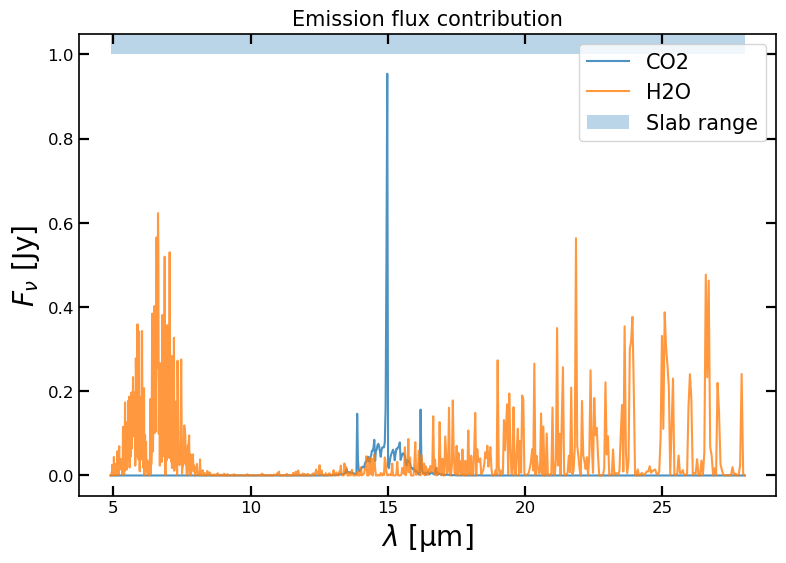

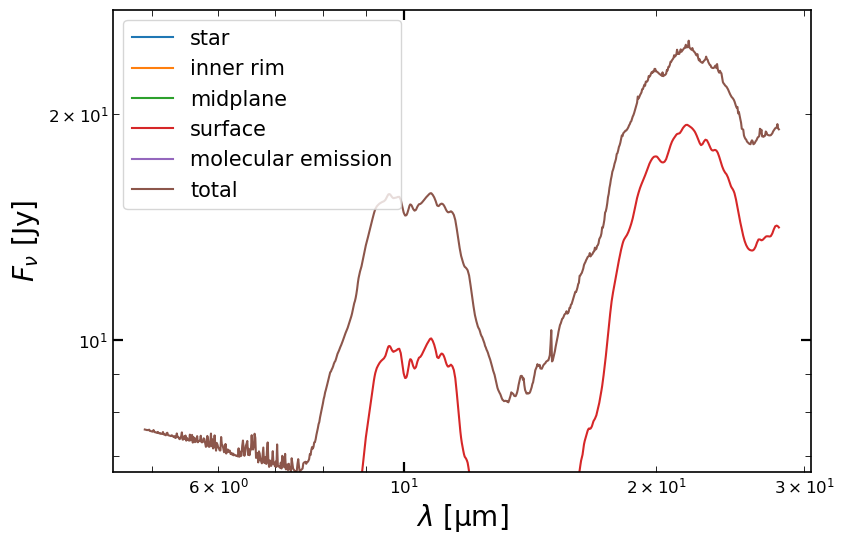

In [18]:

mod.run_model(variables=var_dict,dust_species=abundance_dict,slab_dict=slab_dict,output_all=False,timeit=True)
mod.plot() #this plots the final model


now you can go back and rerun the model with different values and see what changes

# Exploring the model

-----------
CO2
ColDens_tmin 200
ColDens_slope 0.0
logColDens_min 18.0
inner_part_temp [225 250 275 300 325 350 375 400 425 450 475]
inner_part [5.19509033e-19 5.61495947e-19 5.85707115e-19 5.94965452e-19
 5.92413406e-19 5.81058572e-19 5.63473837e-19 5.41738058e-19
 5.17436354e-19 4.91756182e-19 4.65558084e-19]
upper_in_temp 500
lower_in_temp 200
upper_in 2.1972872843149206e-19
lower_in 2.288407025502912e-19
lower_out_temp 200
upper_out_temp 500
lower_out 0.0
upper_out 0.0
-----------
H2O
ColDens_tmin 221
ColDens_slope 0.0
logColDens_min 17.69897000433602
inner_part_temp [250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 650 675
 700 725 750 775 800 825 850 875]
upper_in_temp 900
lower_in_temp 225
lower_out_temp 221
upper_out_temp 921.1
inner_part [1.47103371e-19 1.67833292e-19 1.86195431e-19 2.02080893e-19
 2.15276202e-19 2.25740064e-19 2.33569353e-19 2.38916406e-19
 2.41964211e-19 2.42925419e-19 2.42036638e-19 2.39545529e-19
 2.35696944e-19 2.30722515e-19 2.24834658e-19

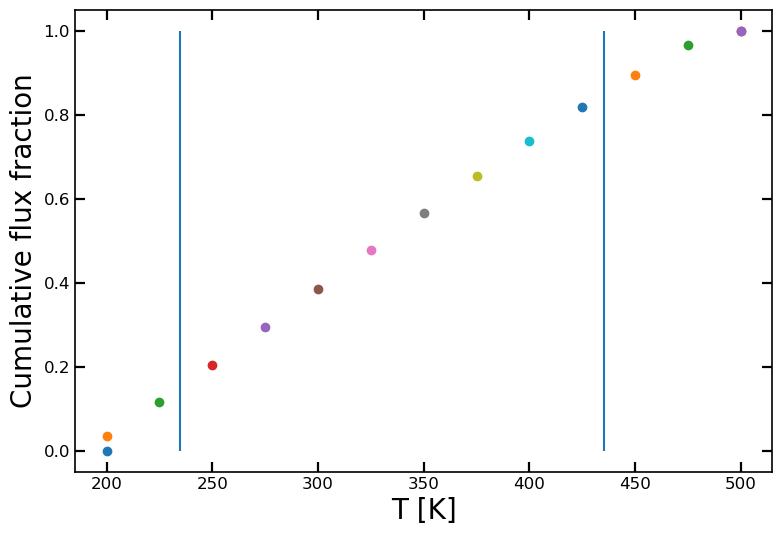

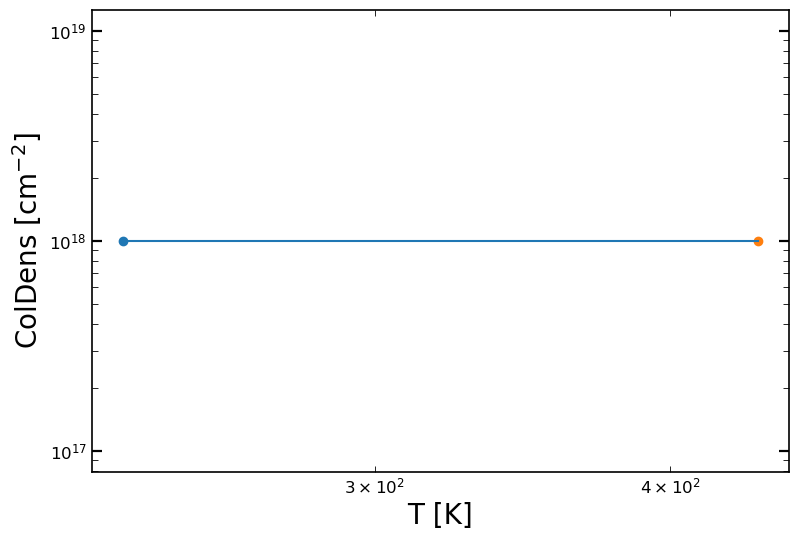

tmax,tmin 500 200
t at max,t at min 435.5484578057624 234.8488015203925


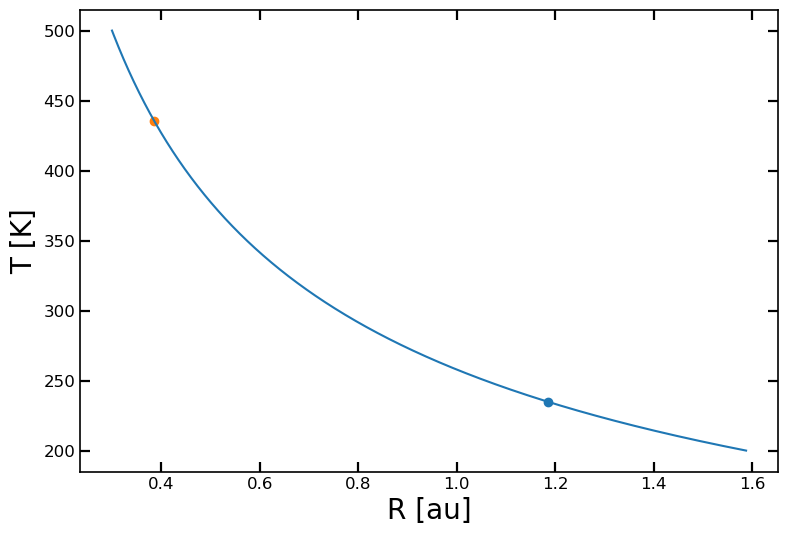

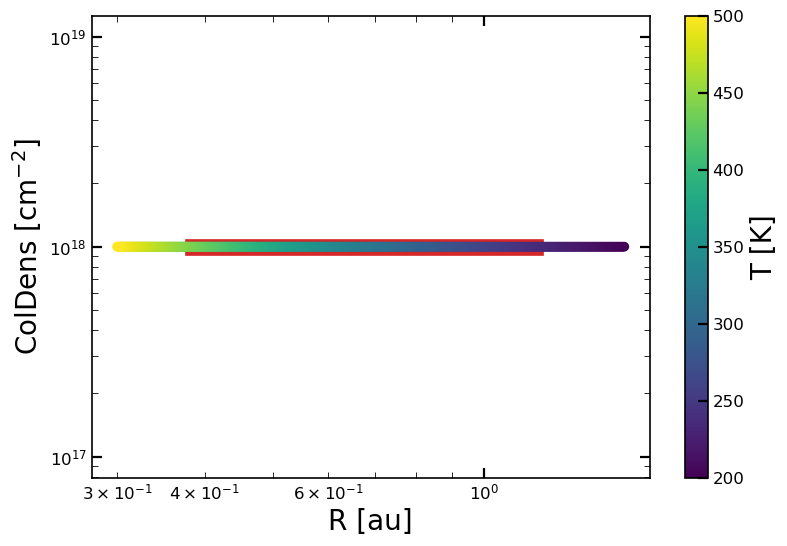

----------------
Keys in output dict
H2O
ColDens_tmin
221
ColDens_slope
0.0
logColDens_min
17.69897000433602
inner_part_temp
[250 275 300 325 350 375 400 425 450 475 500 525 550 575 600 625 650 675
 700 725 750 775 800 825 850 875]
upper_in_temp
900
lower_in_temp
225
lower_out_temp
221
upper_out_temp
921.1
inner_part
[1.47103371e-19 1.67833292e-19 1.86195431e-19 2.02080893e-19
 2.15276202e-19 2.25740064e-19 2.33569353e-19 2.38916406e-19
 2.41964211e-19 2.42925419e-19 2.42036638e-19 2.39545529e-19
 2.35696944e-19 2.30722515e-19 2.24834658e-19 2.18224090e-19
 2.11059659e-19 2.03489446e-19 1.95642397e-19 1.87630031e-19
 1.79548005e-19 1.71477512e-19 1.63486559e-19 1.55631175e-19
 1.47956599e-19 1.40498449e-19]
upper_in
6.664194023562975e-20
upper_out
1.1001206614260435e-19
lower_in
6.192463821393927e-20
lower_out
1.9747023092188088e-20
-----------
H2O
Contributing to total flux: inner_part
Contributing to total flux: upper_in
Contributing to total flux: upper_out
Contributing to total flu

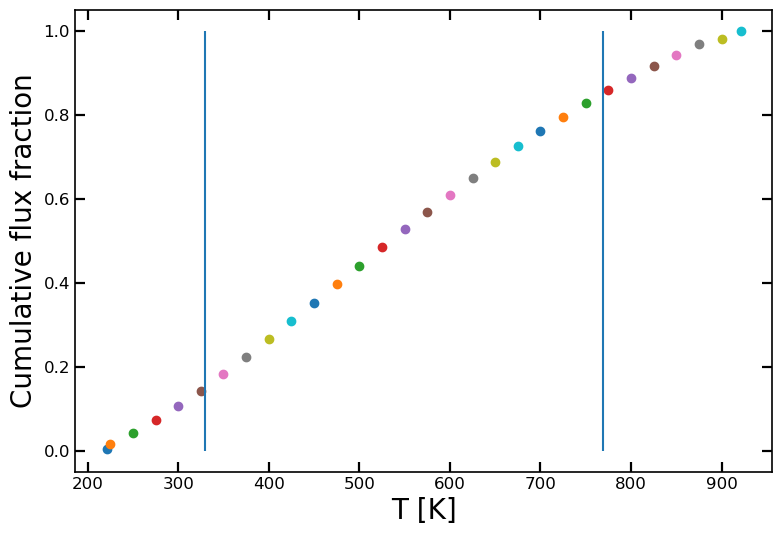

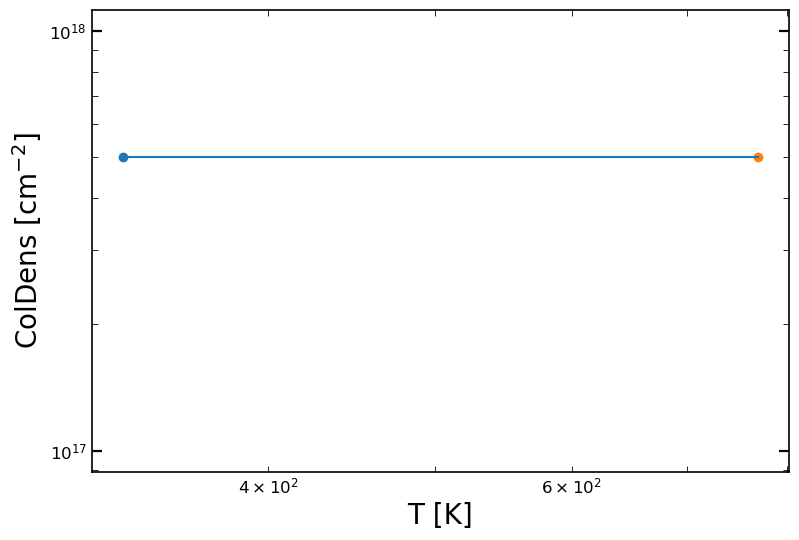

tmax,tmin 921.1 221
t at max,t at min 768.8935449559599 329.7876784782231


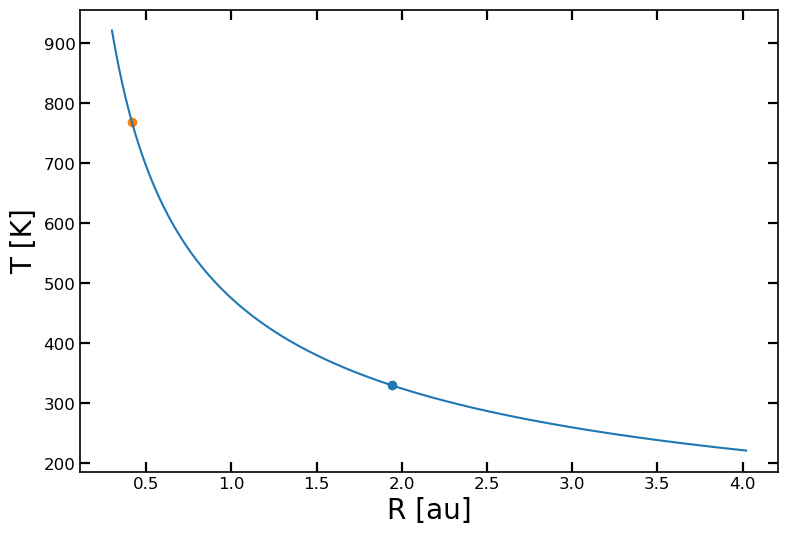

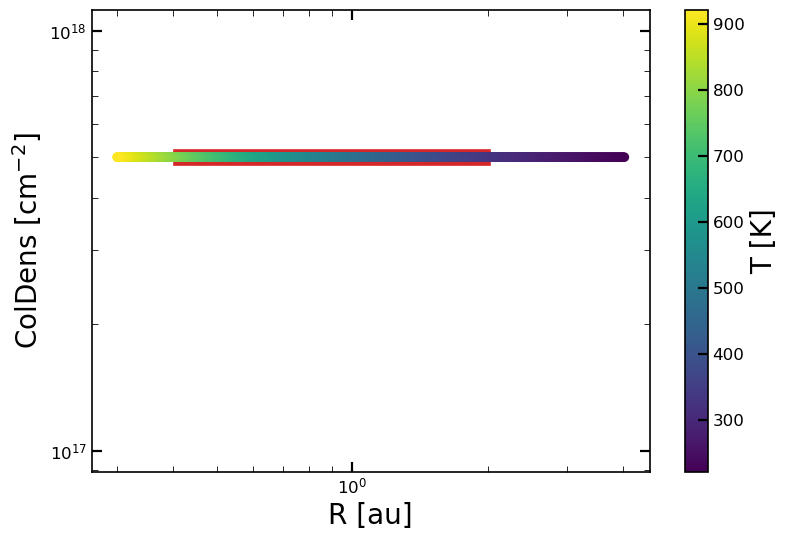

{'CO2': {'radius_eff': 1.120801151760114,
  'tmin,tmax': [234.8488015203925, 435.5484578057624],
  'cmin,cmax': [1e+18, 1e+18],
  'rout,rin': [1.1852642213903253, 0.38555940232500585]},
 'H2O': {'radius_eff': 1.8963847728986825,
  'tmin,tmax': [329.7876784782231, 768.8935449559599],
  'cmin,cmax': [4.9999999999999994e+17, 4.9999999999999994e+17],
  'rout,rin': [1.9416095678339453, 0.41662033918464975]}}

In [24]:
#calculating where the emission in the model is coming from
mod.extract_emission_quantities(debug=True)

In [21]:
#calculating the integrated flux of a molecule in a certain wavelength range
mod.calc_integrated_flux('H2O',wave_lims=[14,16])

3.291790914575917e-16

# Others

There are more modes that you can run, like just the slab part of the model.  
I'll create tutorials on that later